In [1]:
# change the display more comfortable
import seaborn as sbn
sbn.set()

from IPython.display import HTML
CSS="""#notebook-container {
    width: 100%
}

.code_cell {
   flex-direction: row !important;
}

.code_cell .input {
    width: 50%
}

.code_cell .output_wrapper {
    width: 50%
}"""
HTML('<style>{}</style>'.format(CSS))

In [2]:
# -*- coding: utf-8 -*-
__author__ = 'huangyf'

import os
import re
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from torch import nn, optim
from data_loader import get_loader
from torchvision import transforms
from models import resnet
from utils import AverageMeter, accuracy, get_margin, ramp_loss, margin_error, get_Lip

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

use_gpu = torch.cuda.is_available()


def train_model(model, criterion, optimizer, log_saver, g0, num_epochs=100):
    since = time.time()
    steps = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'train1', 'test']:

            margin = []
            loss_meter = AverageMeter()
            rloss_meter = AverageMeter()
            ramp_loss_meter = AverageMeter()
            acc_meter = AverageMeter()
            margin_error_meter = AverageMeter()

            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            for i, data in enumerate(loaders[re.findall('[a-zA-Z]+',
                                                        phase)[0]]):
                inputs, labels = data
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    steps += 1

                N = outputs.size(0)

                margin = np.append(margin, get_margin(outputs, labels))
                loss_meter.update(loss.data.item(), N)
                acc_meter.update(
                    accuracy(outputs.data, labels.data)[-1].item(), N)

                if phase != 'train':
                    gamma = log_saver['Lip'][-1] * g0
                    ramp_loss_meter.update(
                        ramp_loss(get_margin(outputs, labels), gamma), N)
                    rloss_meter.update(
                        criterion(outputs / log_saver['Lip'][-1],
                                  labels).data.item(), N)
                    margin_error_meter.update(
                        margin_error(get_margin(outputs, labels), gamma), N)

            epoch_loss = loss_meter.avg
            epoch_error = 1 - acc_meter.avg / 100

            if phase == 'train':
                model.eval()
                log_saver['Lip'].append(get_Lip(model,'resnet18'))

            if phase == 'train1':

                log_saver['train_loss'].append(epoch_loss)
                log_saver['train_error'].append(epoch_error)
                log_saver['margin_train'].append(margin)
                log_saver['train_rloss'].append(rloss_meter.avg)
                log_saver['train_ramp_loss'].append(ramp_loss_meter.avg)
                log_saver['train_margin_error'].append(margin_error_meter.avg)

            elif phase == 'test':

                log_saver['test_loss'].append(epoch_loss)
                log_saver['test_error'].append(epoch_error)
                log_saver['margin_test'].append(margin)
                log_saver['test_rloss'].append(rloss_meter.avg)
                log_saver['test_ramp_loss'].append(ramp_loss_meter.avg)
                log_saver['test_margin_error'].append(margin_error_meter.avg)

            if phase != 'train':
                print(
                    f'{phase} Loss: {epoch_loss:.4f} rLoss: {rloss_meter.avg:.4f} Error: {epoch_error:.4f}',
                    f'RampLoss: {ramp_loss_meter.avg:.6f} MarginError: {margin_error_meter.avg:.4f}',
                    f"Margin: {min(margin):.4f} Lip: {log_saver['Lip'][-1]:.4e}"
                )

        if epoch % 30 == 0 or epoch == num_epochs - 1:
            print('Saving..')
            state = {'net': model, 'epoch': epoch, 'log': log_saver}

            if not os.path.isdir('checkpoint_CNN'):
                os.mkdir('checkpoint_CNN')
            torch.save(state,
                       './checkpoint_CNN/ckpt_epoch_{}.t7'.format(epoch))

    time_elapsed = time.time() - since
    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s'
    )

    return model, log_saver

/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [38]:
def plot(log, q, result_dir):
    fontdict = {'size': 30}

    def get_fig(i, title):
        fig = plt.figure(i, figsize=(20, 10))
        ax = fig.add_subplot(111)
        #plt.title(title, fontsize=30, y=1.04)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        return fig, ax

    def get_qmargin(margins, q):
        q1 = int(len(margins[0]) * q)
        return [np.partition(margin, q1)[q1] for margin in margins]

    fig1, ax1 = get_fig(1, 'Loss on Cifar10')
    fig2, ax2 = get_fig(2, 'Error on Cifar10')
    fig4, ax4 = get_fig(4, 'Margin($\gamma$) of 5-layer CNN on Cifar10')
    fig5, ax5 = get_fig(5, r'Normalised Margin')
    fig7, ax7 = get_fig(7, r'Normalised qMargin(.8)')
    fig8, ax8 = get_fig(8, r'qMargin(.8)')
    fig9, ax9 = get_fig(9, r'Rademacher Complexity')
    fig10, ax10 = get_fig(10, r'train rloss and test rloss')
    fig11, ax11 = get_fig(11, r'train rloss and test error')
    fig12, ax12 = get_fig(12, r'rc and test error')
    fig13, ax13 = get_fig(13, r'rloss')
    fig14, ax14 = get_fig(14, r'ramp loss')
    fig15, ax15 = get_fig(15, r'margin error and test error')
    fig16, ax16 = get_fig(16, r'margin error')

    ax1.plot(log['train_loss'],'r', linewidth=3, label='training')
    ax1.plot(log['test_loss'],'b', linewidth=3, label='test')
    ax1.set_ylabel('loss',fontdict=fontdict)
    ax2.plot(log['train_error'],'r', linewidth=3, label='training')
    ax2.plot(log['test_error'],'b', linewidth=3, label='test')
    ax2.set_ylabel('error',fontdict=fontdict)
    ax4.plot(
        [min(x) for x in log['margin_train']],'r', linewidth=3, label='training')
    ax4.plot([min(x) for x in log['margin_test']],'b', linewidth=3, label='test')

    ax14.plot(log['train_ramp_loss'],'r', linewidth=3, label='training')
    ax14.plot(log['test_ramp_loss'],'b', linewidth=3, label='test')

    ax8.plot(
        get_qmargin(log['margin_train'], q),'r', linewidth=3, label='training')
    ax8.plot(get_qmargin(log['margin_test'], q),'b', linewidth=3, label='test')
    ax13.plot(log['train_rloss'],'r', linewidth=3, label='training')
    ax13.plot(log['test_rloss'],'b', linewidth=3, label='test')

    ax16.plot(log['train_margin_error'],'r', linewidth=3, label='training')
    ax16.plot(log['test_margin_error'],'b', linewidth=3, label='test')

    log['nMargin_train'] = np.array([min(x) for x in log['margin_train']
                                     ]) / np.array(log['Lip'])
    log['nMargin_test'] = np.array([min(x) for x in log['margin_test']
                                    ]) / np.array(log['Lip'])

    ax5.plot(log['nMargin_train'],'r', linewidth=3, label='training')
    ax5.plot(log['nMargin_test'],'b', linewidth=3, label='test')

    log['nqMargin_train'] = np.array(get_qmargin(log['margin_train'],
                                                 q)) / np.array(log['Lip'])
    log['nqMargin_test'] = np.array(get_qmargin(log['margin_test'],
                                                q)) / np.array(log['Lip'])

    ax7.plot(1/log['nqMargin_train']*1e-23,'r', linewidth=3, label=r'$1/\hat{\rho}_{q^{\ast}}$')
    ax7.plot(log['test_error'],'b', linewidth=3, label='test error')
    ax7.set_ylim(0,1)
    x1=np.argmin(1/log['nqMargin_train'])
    x2=np.argmin(log['test_error'])
    ax7.plot([x1,x1],[0,1/log['nqMargin_train'][x1]*1e-23],'r--')
    ax7.plot([x2,x2],[0,log['test_error'][x2]],'b--')
    ax7.set_xticks([0,min(x1,x2),max(x1,x2),20,40,60,100])

    ax9.plot(
        np.array(log['Lip']) / np.array(get_qmargin(log['margin_train'], 0.3)),
        linewidth=3,
        label='q=0.3')
    ax9.plot(
        np.array(log['Lip']) / np.array(get_qmargin(log['margin_train'], 0.5)),
        linewidth=3,
        label='q=0.5')
    ax9.plot(
        np.array(log['Lip']) / np.array(get_qmargin(log['margin_train'], 0.8)),
        linewidth=3,
        label='q=0.8')

    ax10.scatter(
        log['train_rloss'],
        log['test_rloss'],
        label=
        f"corrcoef= {np.corrcoef(log['train_rloss'], log['test_rloss'])[0,1]:.4f}"
    )

    ax11.scatter(
        log['train_rloss'],
        log['test_error'],
        label=
        f"corrcoef= {np.corrcoef(log['train_rloss'], log['test_error'])[0,1]:.4f}"
    )

    log['RC'] = np.array(log['Lip']) / np.array(
        get_qmargin(log['margin_train'], q))
    ax12.scatter(
        log['RC'][10:],
        log['test_error'][10:],
        label=
        f"corrcoef= {np.corrcoef(log['RC'][10:], log['test_error'][10:])[0,1]:.4f}"
    )

    ax15.scatter(
        log['train_margin_error'],
        log['test_error'],
        label=
        f"corrcoef= {np.corrcoef(log['train_margin_error'], log['test_error'])[0,1]:.4f}"
    )

    for ax in [ax1, ax2, ax4, ax5, ax7, ax8, ax9, ax13, ax14, ax16]:
        ax.set_xlabel('Number of epochs', fontdict=fontdict)
        ax.legend(loc='upper right', fontsize=20)

    ax10.set_xlabel('train rloss', fontdict=fontdict)
    ax10.set_ylabel('test rloss', fontdict=fontdict)
    ax10.legend(loc='upper right', fontsize=20)

    ax11.set_xlabel('train rloss', fontdict=fontdict)
    ax11.set_ylabel('test error', fontdict=fontdict)
    ax11.legend(loc='upper right', fontsize=20)

    ax12.set_xlabel('train RC', fontdict=fontdict)
    ax12.set_ylabel('test error', fontdict=fontdict)
    ax12.legend(loc='upper right', fontsize=20)

    ax15.set_xlabel('train margin error', fontdict=fontdict)
    ax15.set_ylabel('test error', fontdict=fontdict)
    ax15.legend(loc='upper right', fontsize=20)

    if not os.path.exists(result_dir):
        os.mkdir(result_dir)
    fig1.savefig(result_dir + 'loss.png')
    fig2.savefig(result_dir + 'error.png')
    fig4.savefig(result_dir + 'margin.png')
    fig5.savefig(result_dir + 'n_margin.png')
    fig7.savefig(result_dir + 'nq_margin.png')
    fig8.savefig(result_dir + 'q_margin.png')
    fig9.savefig(result_dir + 'rc.png')
    fig10.savefig(result_dir + 'rloss_rloss.png')
    fig11.savefig(result_dir + 'rloss_error.png')
    fig12.savefig(result_dir + 'rc_error.png')
    fig13.savefig(result_dir + 'rloss.png')
    fig14.savefig(result_dir + 'ramp_loss.png')
    fig15.savefig(result_dir + 'margin_error_test_error.png')
    fig16.savefig(result_dir + 'margin_error.png')

In [4]:
#%%
root = './'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'original'
g0 = 1

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

log = {
    'num_params': [],
    'train_loss': [],
    'train_rloss': [],
    'train_error': [],
    'train_margin_error': [],
    'train_ramp_loss': [],
    'test_ramp_loss': [],
    'test_loss': [],
    'test_rloss': [],
    'test_error': [],
    'test_margin_error': [],
    'Lip': [],
    'margin_train': [],
    'margin_test': []
}

# %% run the model
num_epochs = 100
model = resnet.ResNet18()

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

log['num_params'].append(number_params)

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

****** label mode: original ******


/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


total parameters: 11173962


## Experiment on CIFAR10 with noise=0 for ResNet18
The figures were not modified because we did not show in the paper.

In [4]:
model, log = train_model(
    model, criterion, optimizer, log, g0, num_epochs=num_epochs)

Epoch 1/100
----------
train1 Loss: 1.2183 rLoss: 2.3026 Error: 0.4358 RampLoss: 1.000000 MarginError: 1.0000 Margin: -11.9002 Lip: 6.1831e+23
test Loss: 1.2576 rLoss: 2.3026 Error: 0.4566 RampLoss: 1.000000 MarginError: 1.0000 Margin: -8.7333 Lip: 6.1831e+23
Saving..
Epoch 2/100
----------
train1 Loss: 1.1775 rLoss: 2.3026 Error: 0.3927 RampLoss: 1.000000 MarginError: 1.0000 Margin: -13.6017 Lip: 3.4636e+23
test Loss: 1.2859 rLoss: 2.3026 Error: 0.4254 RampLoss: 1.000000 MarginError: 1.0000 Margin: -11.2480 Lip: 3.4636e+23
Epoch 3/100
----------
train1 Loss: 0.7874 rLoss: 2.3026 Error: 0.2791 RampLoss: 1.000000 MarginError: 1.0000 Margin: -8.7410 Lip: 2.8609e+23
test Loss: 0.9356 rLoss: 2.3026 Error: 0.3271 RampLoss: 1.000000 MarginError: 1.0000 Margin: -9.6608 Lip: 2.8609e+23
Epoch 4/100
----------
train1 Loss: 0.6459 rLoss: 2.3026 Error: 0.2277 RampLoss: 1.000000 MarginError: 1.0000 Margin: -8.0813 Lip: 2.5631e+23
test Loss: 0.8696 rLoss: 2.3026 Error: 0.3008 RampLoss: 1.000000 Marg

test Loss: 0.8137 rLoss: 2.3026 Error: 0.2003 RampLoss: 1.000000 MarginError: 1.0000 Margin: -16.6451 Lip: 2.2087e+23
Epoch 33/100
----------
train1 Loss: 0.0002 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 5.5393 Lip: 2.2072e+23
test Loss: 0.8178 rLoss: 2.3026 Error: 0.2023 RampLoss: 1.000000 MarginError: 1.0000 Margin: -16.4540 Lip: 2.2072e+23
Epoch 34/100
----------
train1 Loss: 0.0002 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 5.2153 Lip: 2.1978e+23
test Loss: 0.8193 rLoss: 2.3026 Error: 0.2002 RampLoss: 1.000000 MarginError: 1.0000 Margin: -16.8281 Lip: 2.1978e+23
Epoch 35/100
----------
train1 Loss: 0.0001 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 5.6478 Lip: 2.2085e+23
test Loss: 0.8218 rLoss: 2.3026 Error: 0.2014 RampLoss: 1.000000 MarginError: 1.0000 Margin: -17.2129 Lip: 2.2085e+23
Epoch 36/100
----------
train1 Loss: 0.0002 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError

train1 Loss: 0.0001 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 6.1527 Lip: 2.2737e+23
test Loss: 0.8595 rLoss: 2.3026 Error: 0.2018 RampLoss: 1.000000 MarginError: 1.0000 Margin: -17.0803 Lip: 2.2737e+23
Epoch 65/100
----------
train1 Loss: 0.0001 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 6.2549 Lip: 2.3007e+23
test Loss: 0.8595 rLoss: 2.3026 Error: 0.2024 RampLoss: 1.000000 MarginError: 1.0000 Margin: -18.2074 Lip: 2.3007e+23
Epoch 66/100
----------
train1 Loss: 0.0001 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 6.5769 Lip: 2.2645e+23
test Loss: 0.8610 rLoss: 2.3026 Error: 0.2015 RampLoss: 1.000000 MarginError: 1.0000 Margin: -18.1260 Lip: 2.2645e+23
Epoch 67/100
----------
train1 Loss: 0.0001 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 6.4465 Lip: 2.2880e+23
test Loss: 0.8576 rLoss: 2.3026 Error: 0.2023 RampLoss: 1.000000 MarginError: 1.0000 Margin: -18.6470 

train1 Loss: 0.0000 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 6.9427 Lip: 2.3056e+23
test Loss: 0.8826 rLoss: 2.3026 Error: 0.2015 RampLoss: 1.000000 MarginError: 1.0000 Margin: -18.5517 Lip: 2.3056e+23
Epoch 97/100
----------
train1 Loss: 0.0000 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 7.2038 Lip: 2.3379e+23
test Loss: 0.8840 rLoss: 2.3026 Error: 0.2014 RampLoss: 1.000000 MarginError: 1.0000 Margin: -18.9503 Lip: 2.3379e+23
Epoch 98/100
----------
train1 Loss: 0.0000 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 7.1801 Lip: 2.3407e+23
test Loss: 0.8801 rLoss: 2.3026 Error: 0.2016 RampLoss: 1.000000 MarginError: 1.0000 Margin: -18.9853 Lip: 2.3407e+23
Epoch 99/100
----------
train1 Loss: 0.0000 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 7.0007 Lip: 2.3094e+23
test Loss: 0.8846 rLoss: 2.3026 Error: 0.2023 RampLoss: 1.000000 MarginError: 1.0000 Margin: -19.2448 

In [27]:
import pickle
#pickle.dump(log,open('./res18_results_original/log_original.log','wb'))
log=pickle.load(open('./res18_results_original/log_original.log','rb'))

/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


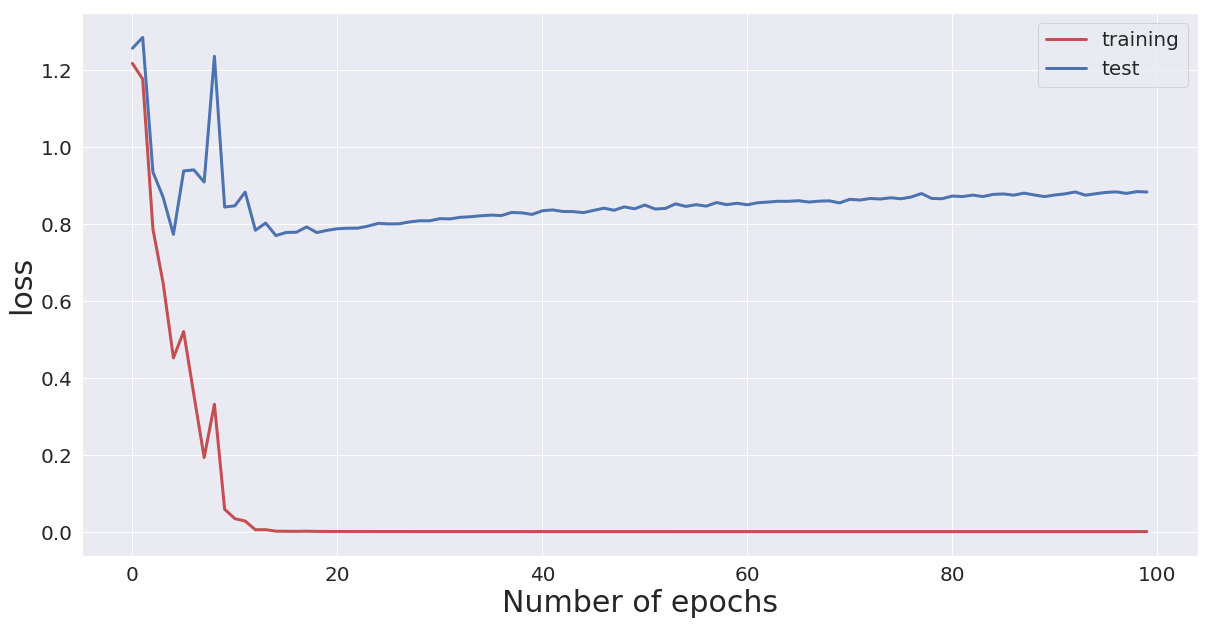

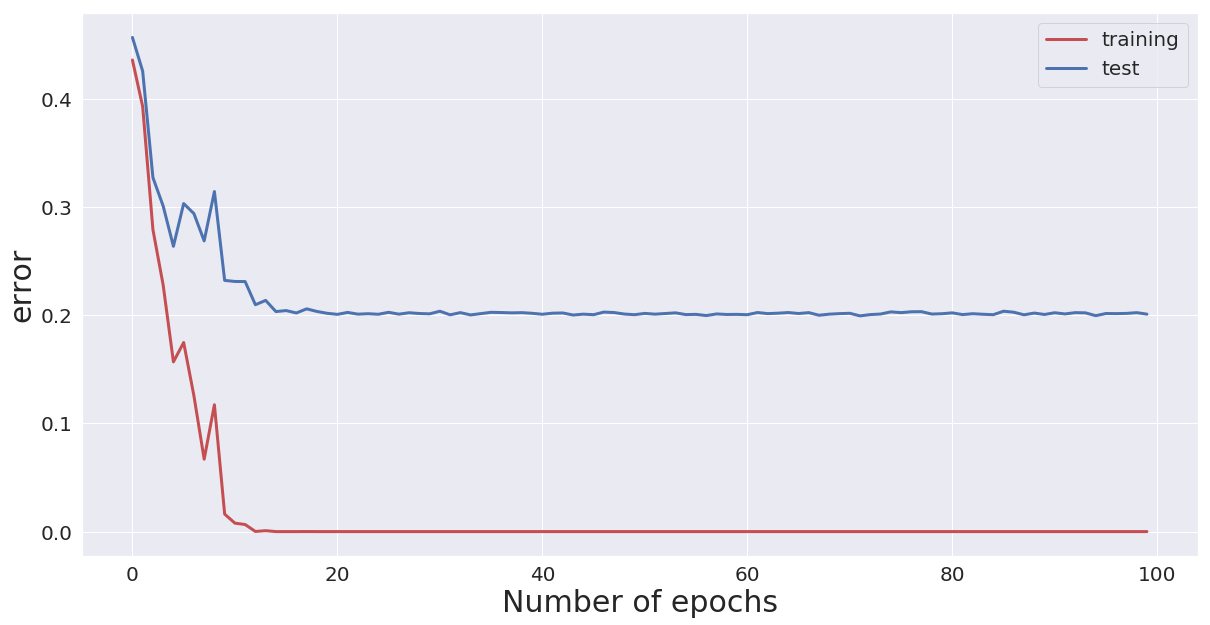

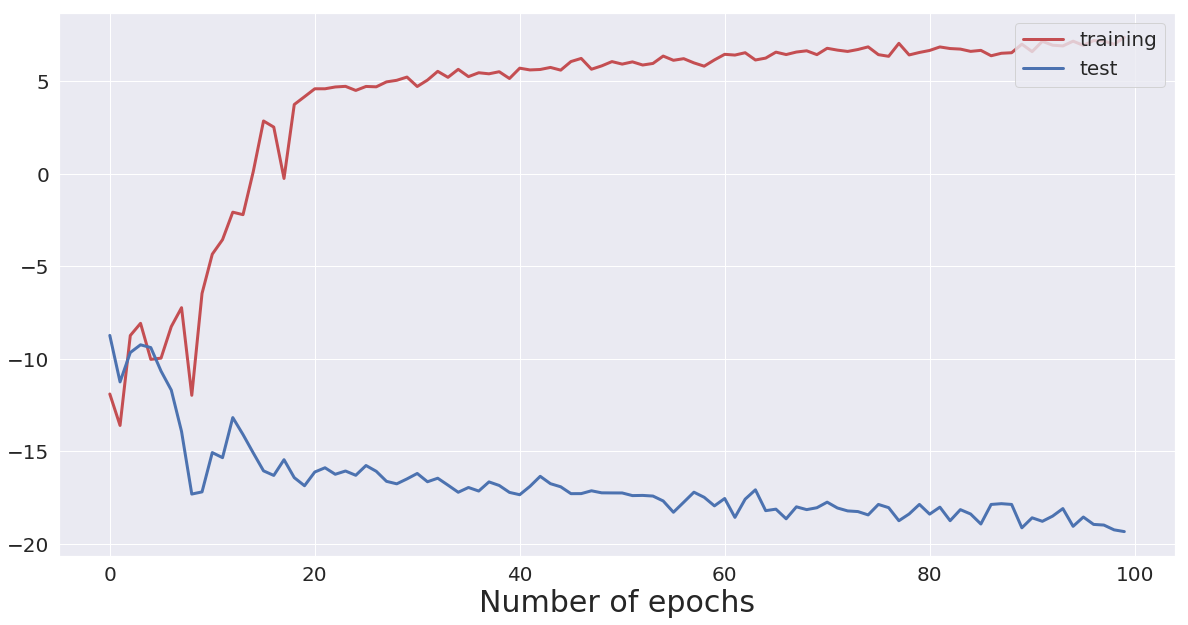

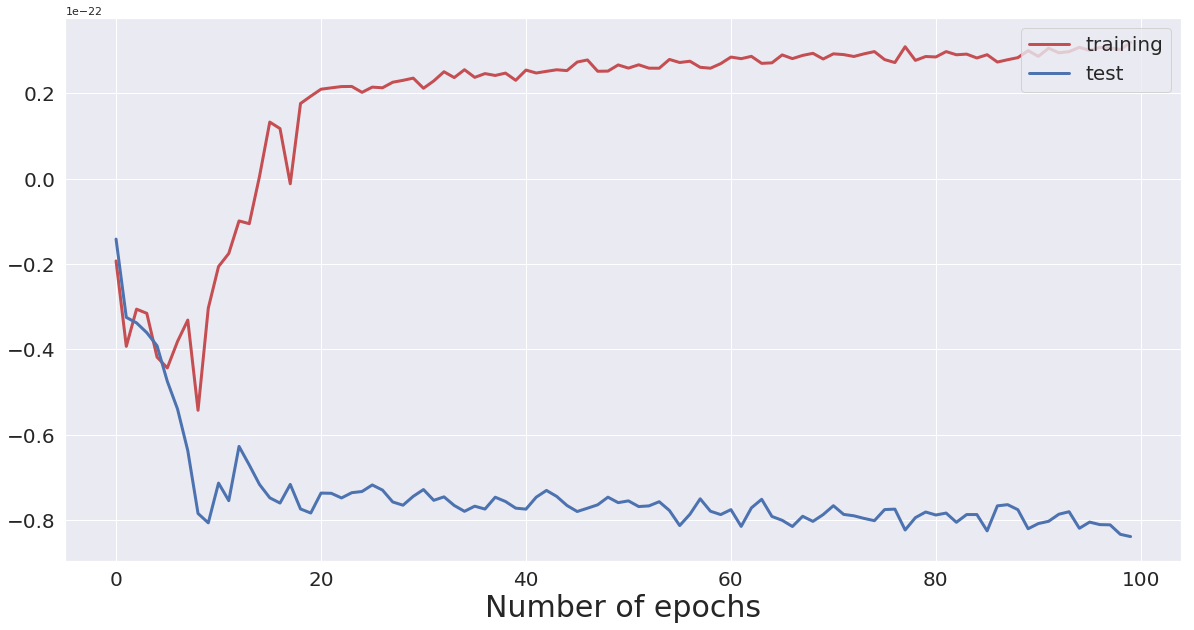

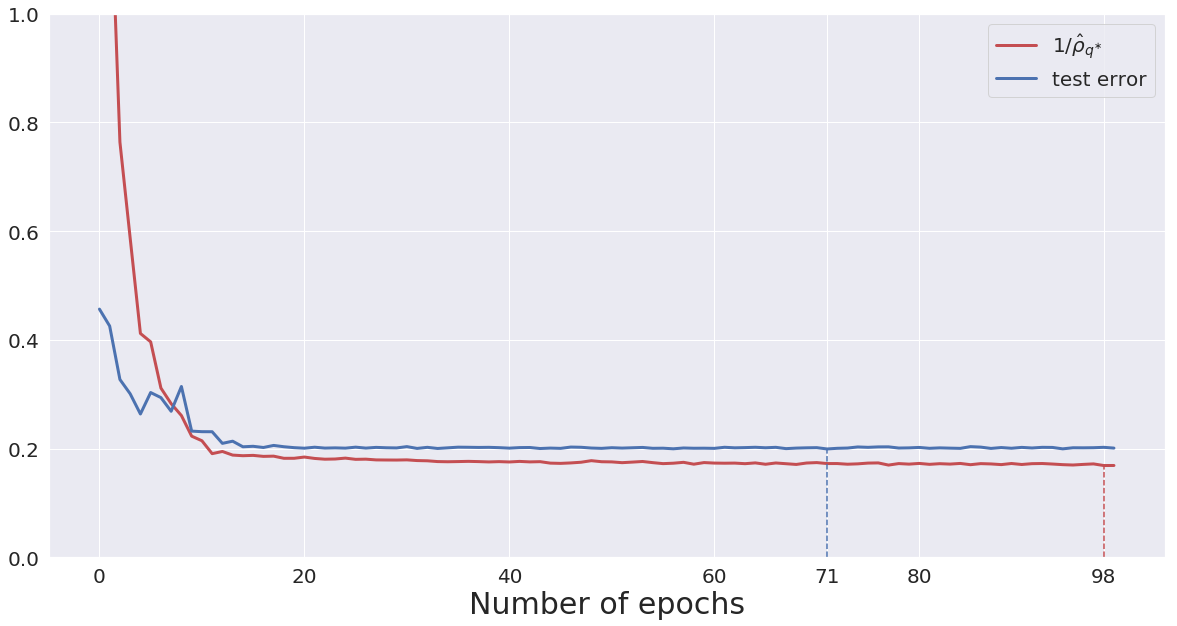

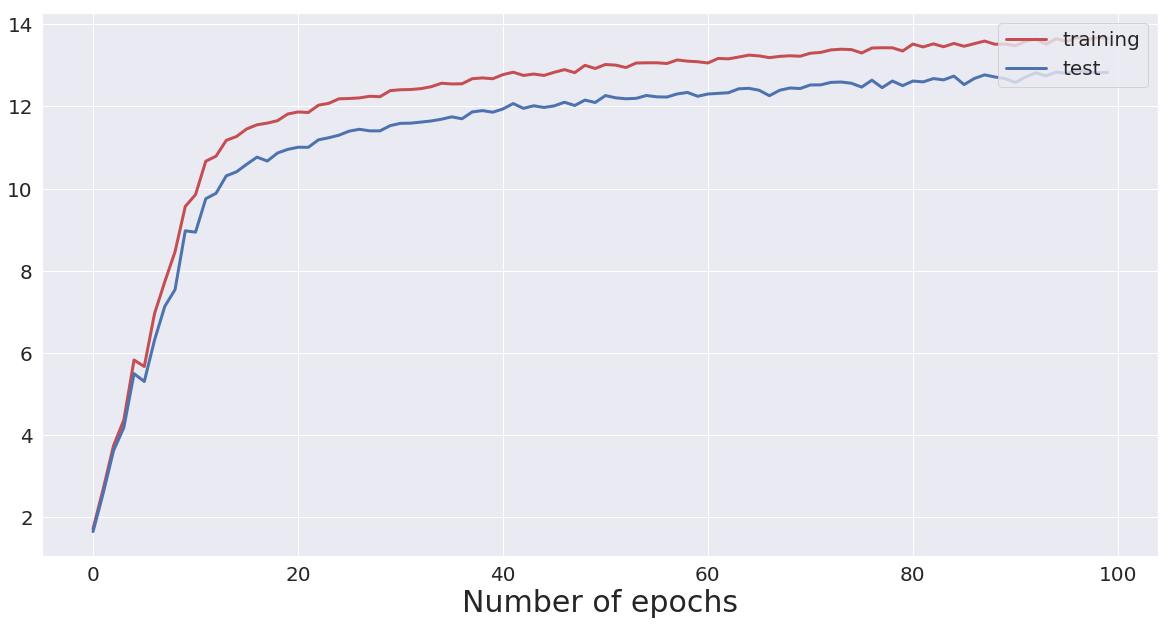

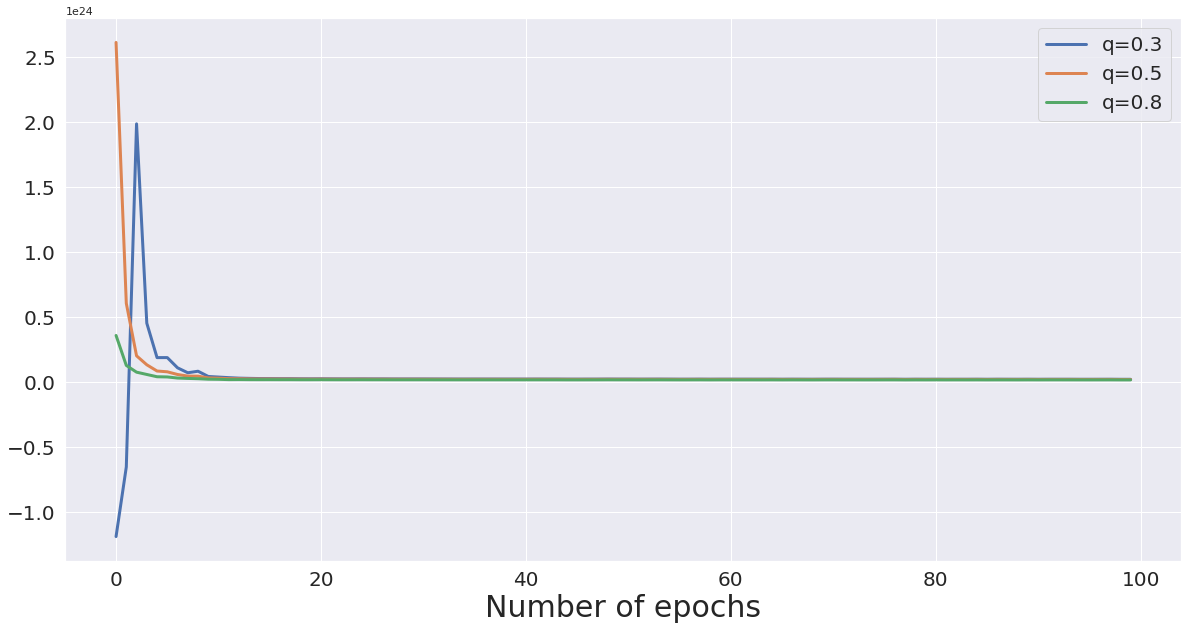

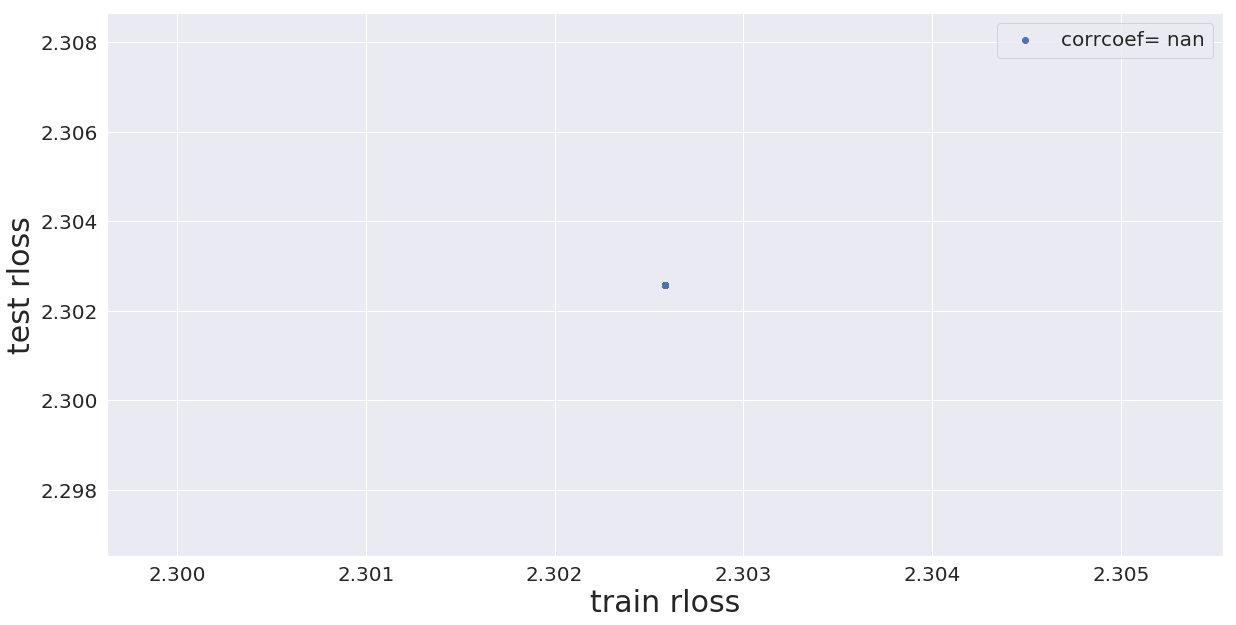

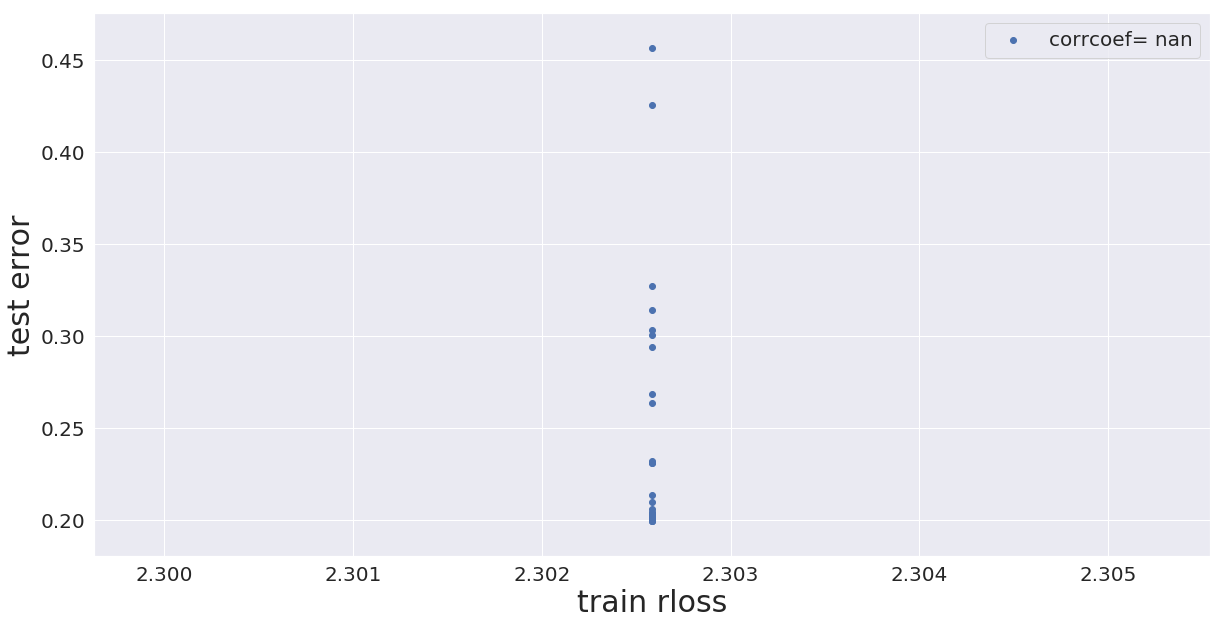

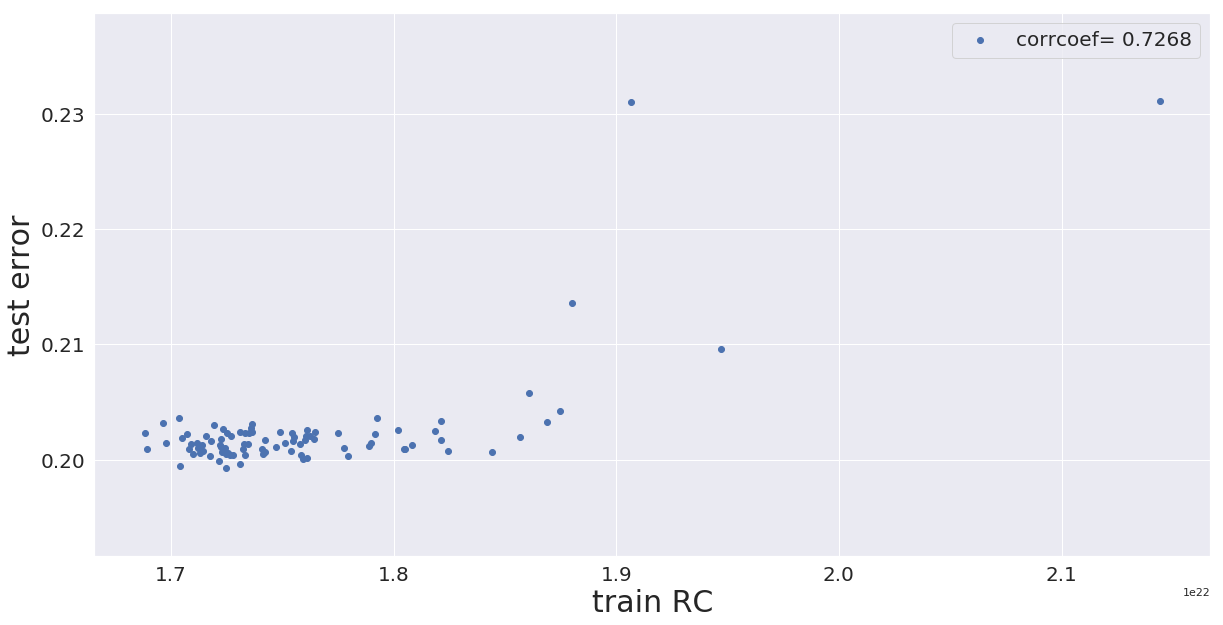

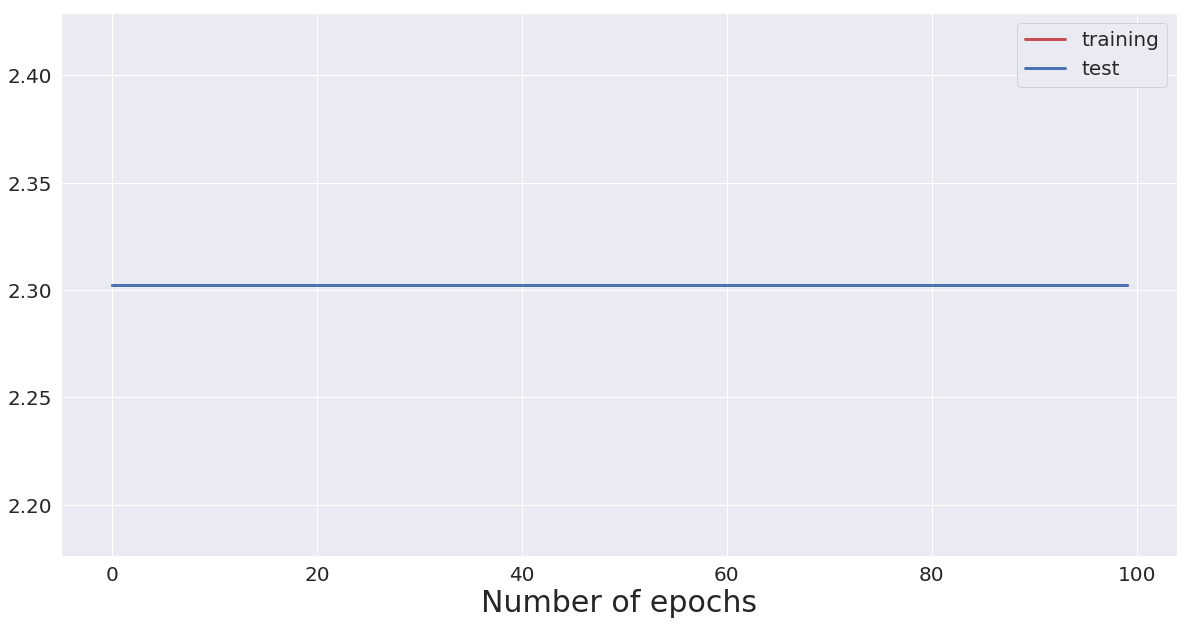

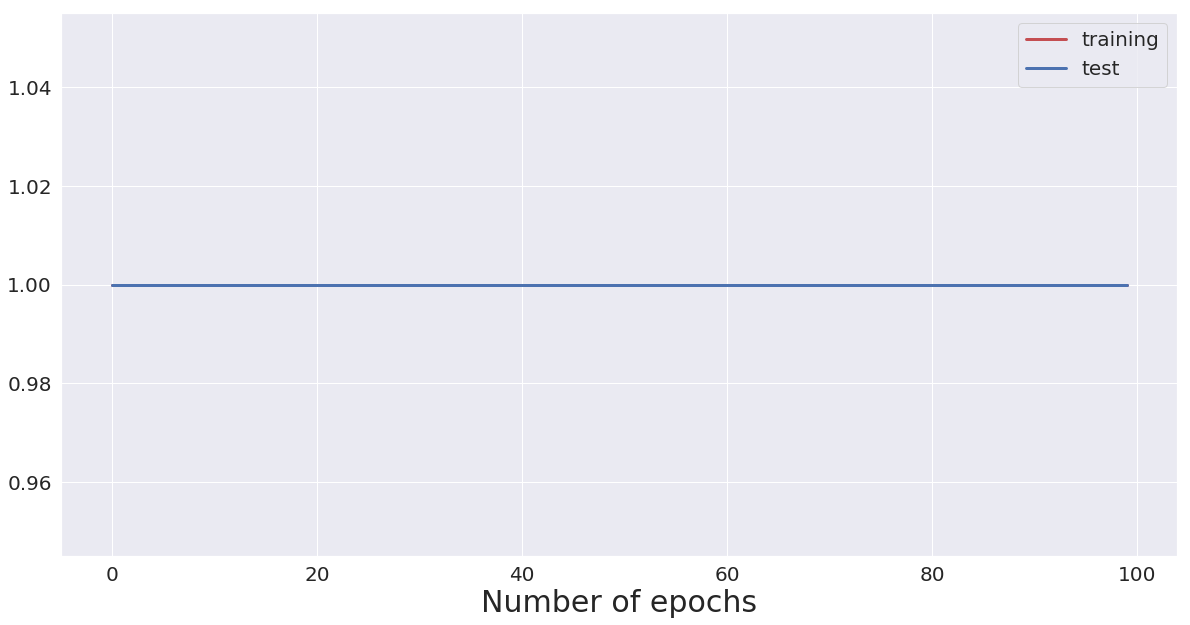

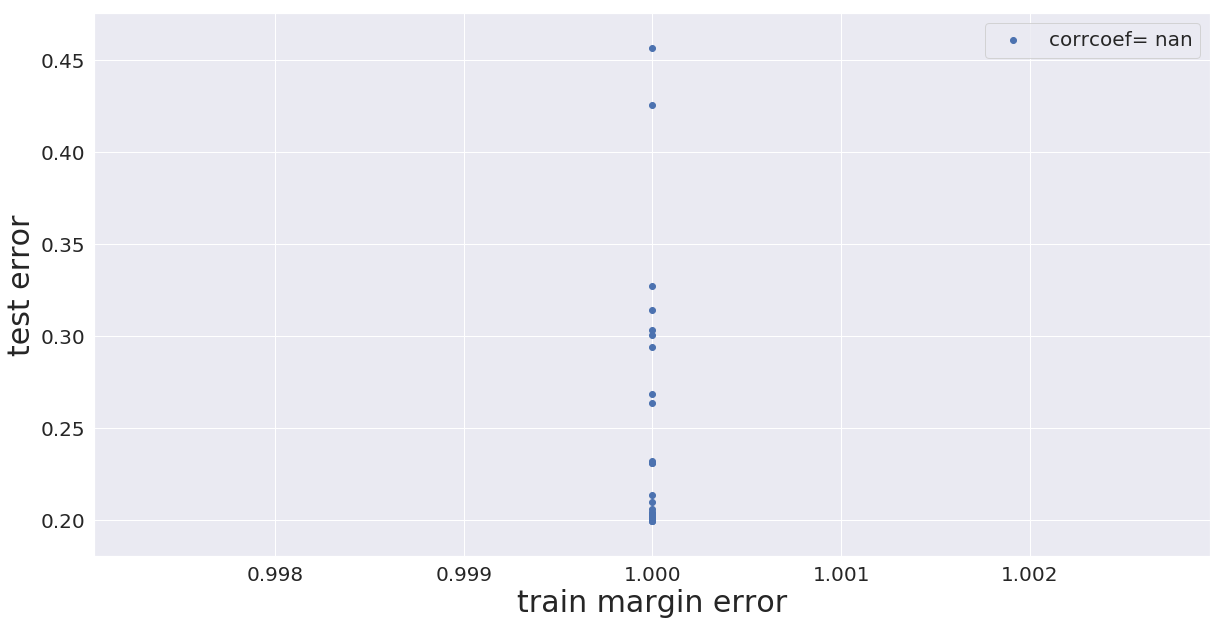

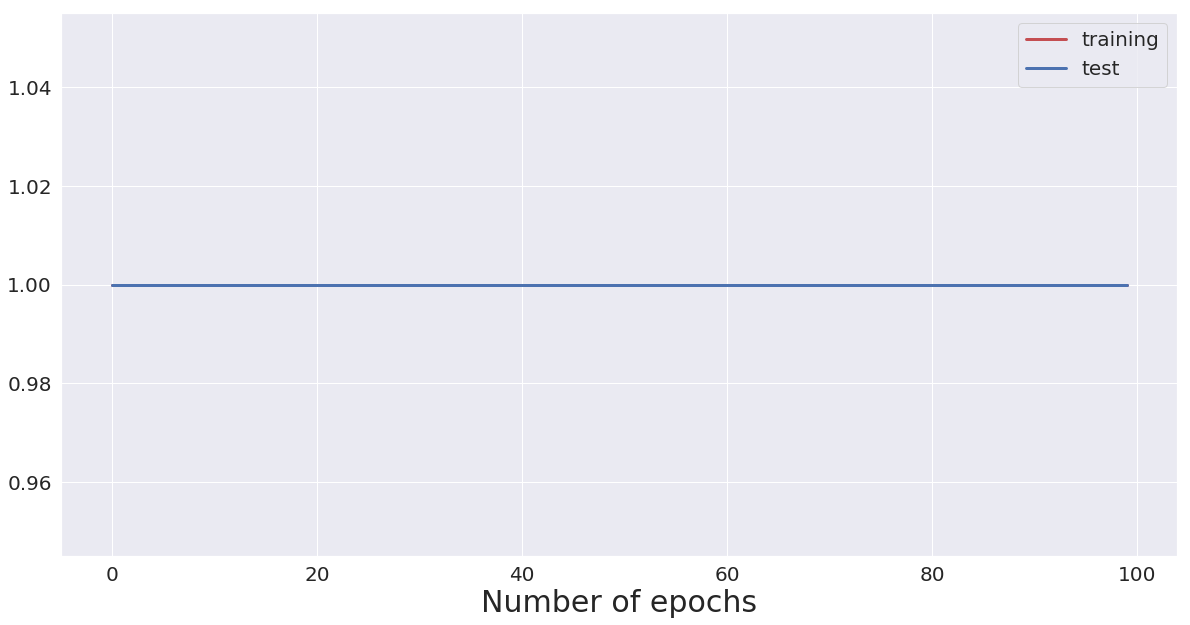

In [34]:
plot(log, 0.8, './res18_results_original/')
plt.show()

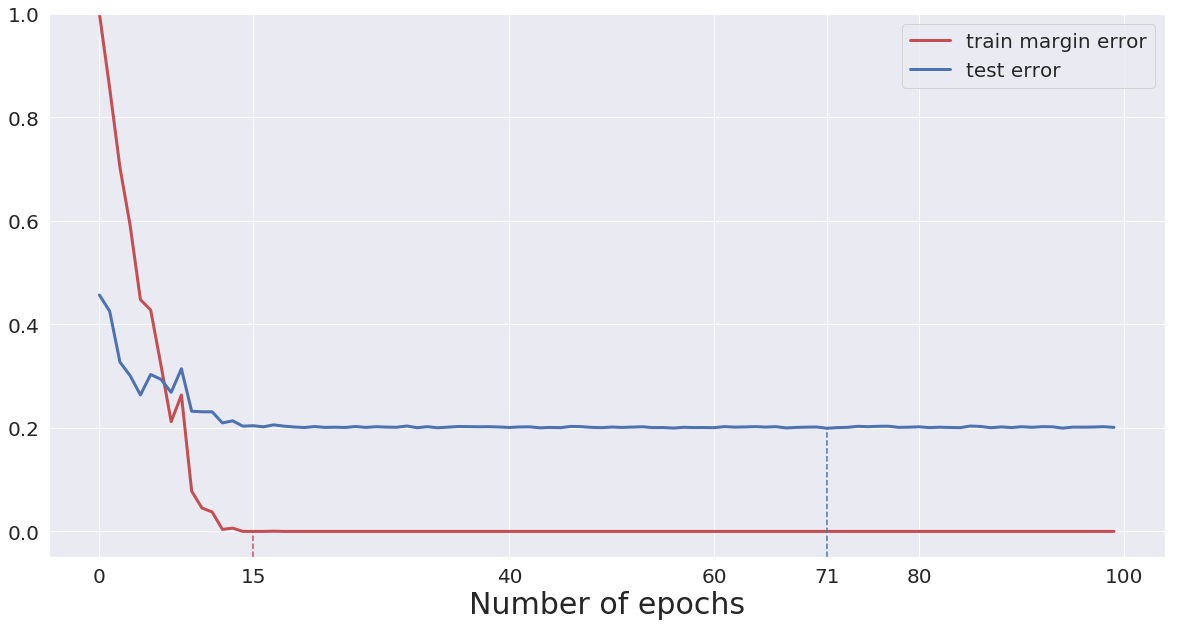

In [35]:
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

train_merror=[margin_error(margin, lip * 1e-23) for (margin, lip) in zip(log['margin_train'], log['Lip'])]
ax.plot(train_merror
    ,'r',linewidth=3,
    label='train margin error')
ax.plot(log['test_error'],'b',linewidth=3,label='test error')
ax.legend(fontsize=20,loc='best')
#ax.set_xlim(0,100)
ax.set_ylim(-0.05,1)
x1=np.argmin(log['test_error'])
ax.plot([x1,x1],[-0.05,log['test_error'][x1]],'b--')
x2=np.argmin(train_merror)
ax.plot([x2,x2],[-0.05,train_merror[x2]],'r--')
ax.set_xticks([0,min(x1,x2),max(x1,x2),40,60,80,100])
ax.set_xlabel('Number of epochs',fontdict={'size': 30})
fig.savefig('./res18_results_original/margin_error_and_test_error.png')

kendall's tau:0.0548
spearman:0.0432


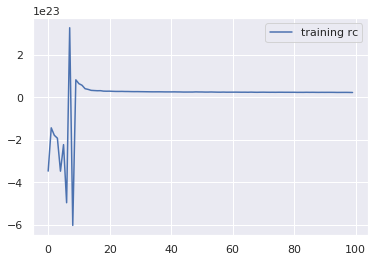

In [10]:
#
import scipy.stats
q = 0.1


def get_qmargin(margins, q):
    q1 = int(len(margins[0]) * q)
    return [np.partition(margin, q1)[q1] for margin in margins]


RC = np.array(log['Lip']) / np.array(get_qmargin(log['margin_train'], q))
plt.plot(RC, label='training rc')
plt.legend()
print("kendall's tau:{:.4f}".format(
    scipy.stats.stats.kendalltau(RC, log['test_error'])[0]))
print("spearman:{:.4f}".format(
    scipy.stats.stats.spearmanr(RC, log['test_error'])[0]))

best q  0.9


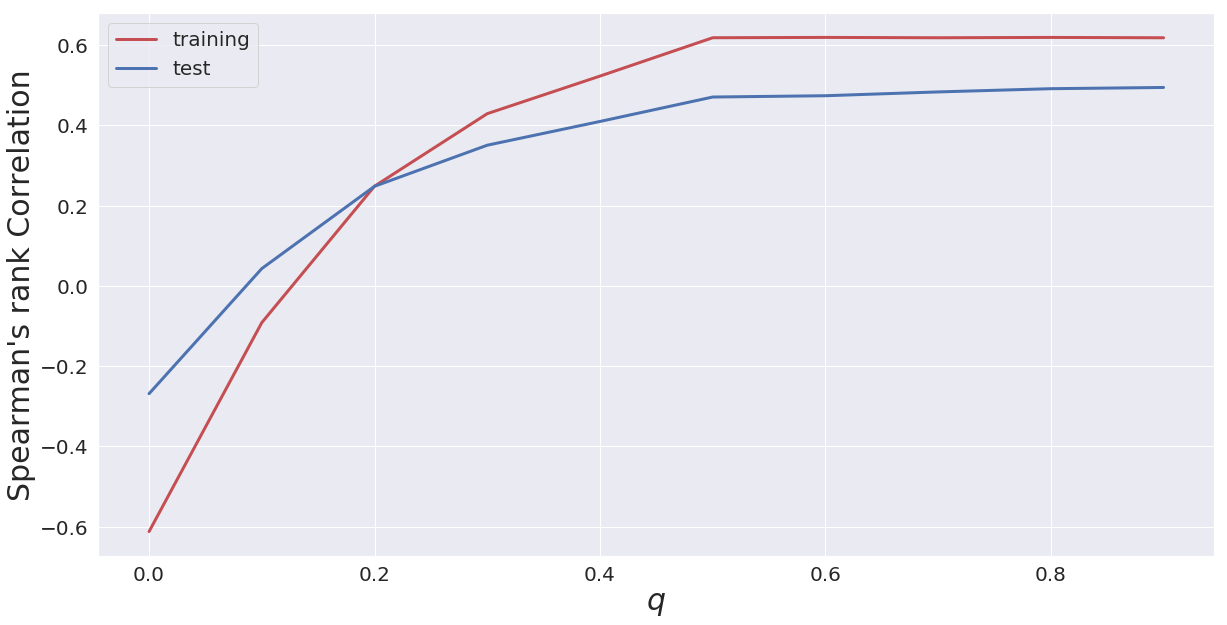

In [11]:
def get_qmargin(margins, q):
    q1 = int(len(margins[0]) * q)
    return [np.partition(margin, q1)[q1] for margin in margins]
spe_train,spe_test = [],[]
qs = np.linspace(0., 0.9, 10)
for q in qs:
    nqMargin_train = np.array(get_qmargin(log['margin_train'], q)) / np.array(
        log['Lip'])
    spe_test.append(
        scipy.stats.stats.spearmanr(1/nqMargin_train, log['test_error'])[0])
    spe_train.append(
        scipy.stats.stats.spearmanr(1/nqMargin_train, log['train_error'])[0])
print('best q ',qs[np.argmax(spe_test)])
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
#plt.title(r'$1/\hat{\rho}_{q}$ and test error', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.plot(qs, spe_train,'r',linewidth=3, label='training')
ax.plot(qs, spe_test,'b',linewidth=3, label='test')
ax.set_xlabel(r'$q$',fontdict={'size':30})
ax.set_ylabel("Spearman's rank Correlation",fontdict={'size':30})
ax.legend(loc='best',fontsize=20)
fig.savefig('./res18_results_original/rank_corr.png')
plt.show()

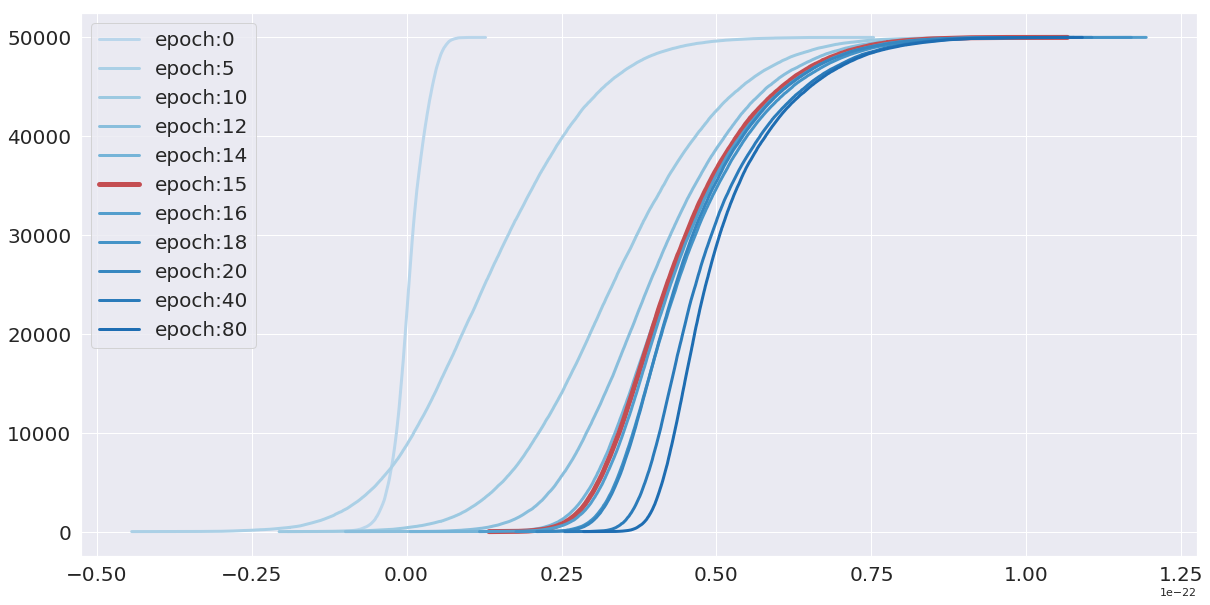

In [10]:
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
#plt.title('Evolutions of normalized margin distributions', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0, 5, 10,12,14,15,16,18,20, 40, 80]):
    if i==15:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',20)[j+5]
        d=3
    ax.plot(np.sort(log['margin_train'][i])/log['Lip'][i], range(50000),c=c, label=f'epoch:{i}',linewidth=d)
#ax.set_xlim([-20, 70])
ax.legend(fontsize=20)
fig.savefig('./res18_results_original/'+'nMargin_distribution.png')

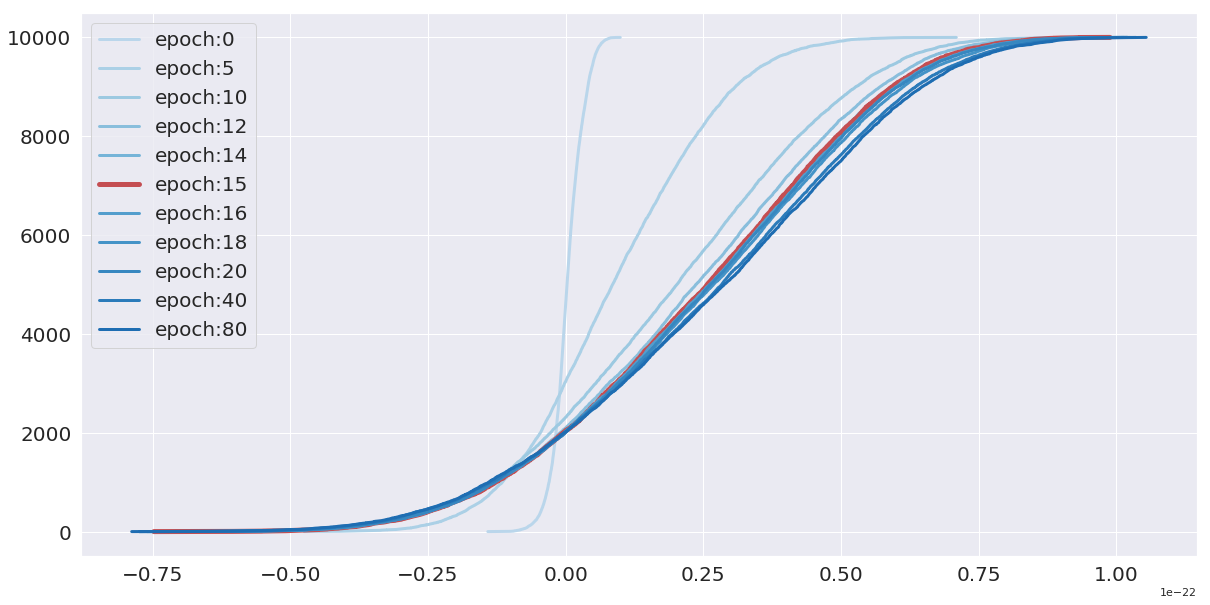

In [11]:
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
#plt.title('Evolutions of normalized margin distributions', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0, 5, 10,12,14,15,16,18,20, 40, 80]):
    if i==15:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',20)[j+5]
        d=3
    ax.plot(np.sort(log['margin_test'][i])/log['Lip'][i], range(10000),c=c, label=f'epoch:{i}',linewidth=d)
#ax.set_xlim([-20, 70])
ax.legend(fontsize=20)
fig.savefig('./res18_results_original/'+'test_nMargin_distribution.png')

In [12]:
def plot_heatmap(log,path,interval):
    n=len(interval)
    corr=np.zeros((n,n))
    corr_linear=np.zeros((n,n))
    for i in range(n):
        g1=interval[i]
        train_merror=[margin_error(margin, lip * g1) for (margin, lip) in zip(log['margin_train'], log['Lip'])]
        for j in range(n):
            g2=interval[j]
            test_merror=[margin_error(margin, lip * g2) for (margin, lip) in zip(log['margin_test'], log['Lip'])]
            corr[i,j]=scipy.stats.spearmanr(train_merror,test_merror)[0]
            corr_linear[i,j]=np.corrcoef(train_merror,test_merror)[0,1]
    fig = plt.figure(1, figsize=(10, 10))
    ax = fig.add_subplot(111)
    im=ax.pcolormesh(interval,interval,corr)
    fig.colorbar(im)
    ax.axis('tight')
    from matplotlib import ticker
    formatter=ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1))
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    fig.savefig(path+'margin_error_rankcorr.png')
    plt.show()
    
    fig = plt.figure(1, figsize=(10, 10))
    ax = fig.add_subplot(111)
    im=ax.pcolormesh(interval,interval,corr_linear)
    fig.colorbar(im)
    ax.axis('tight')
    from matplotlib import ticker
    formatter=ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1))
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    fig.savefig(path+'margin_error_linearcorr.png')
    plt.show()

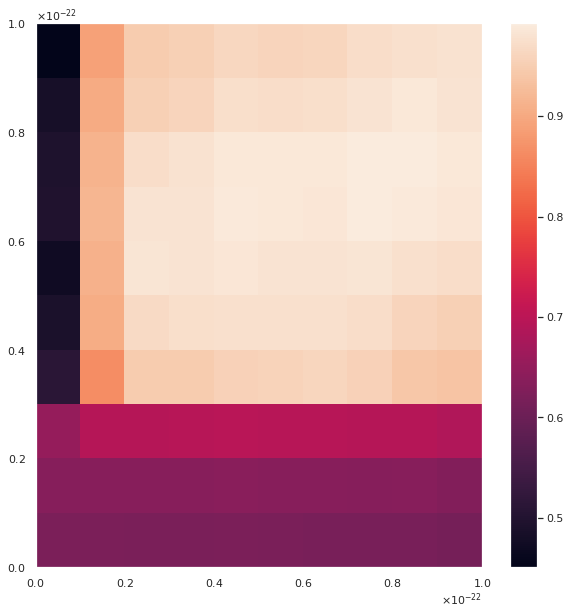

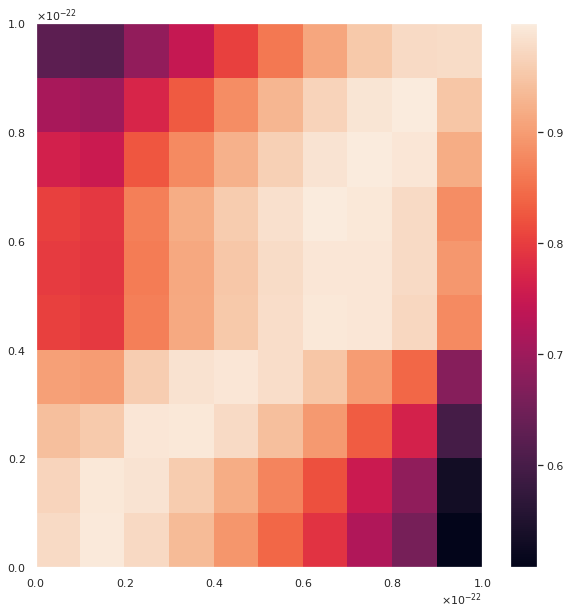

In [24]:
plot_heatmap(log,'./res18_results_original/',np.linspace(0,1e-22,11))

## Experiment on CIFAR10 with noise=0.1 for ResNet18

In [17]:
# %%
root = './'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'partially-0.1'
g0 = 1

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

log_1 = {
    'num_params': [],
    'train_loss': [],
    'train_rloss': [],
    'train_error': [],
    'train_margin_error': [],
    'train_ramp_loss': [],
    'test_ramp_loss': [],
    'test_loss': [],
    'test_rloss': [],
    'test_error': [],
    'test_margin_error': [],
    'Lip': [],
    'margin_train': [],
    'margin_test': []
}

# %% run the model
num_epochs = 100
model = resnet.ResNet18()

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

log_1['num_params'].append(number_params)

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

****** label mode: partially-0.1 ******


/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


total parameters: 11173962


In [18]:
model, log_1 = train_model(
    model, criterion, optimizer, log_1, g0, num_epochs=num_epochs)

Epoch 1/100
----------
train1 Loss: 1.5605 rLoss: 2.3026 Error: 0.5283 RampLoss: 1.000000 MarginError: 1.0000 Margin: -8.8783 Lip: 5.8430e+23
test Loss: 1.5818 rLoss: 2.3026 Error: 0.5383 RampLoss: 1.000000 MarginError: 1.0000 Margin: -7.6774 Lip: 5.8430e+23
Saving..
Epoch 2/100
----------
train1 Loss: 1.3474 rLoss: 2.3026 Error: 0.4396 RampLoss: 1.000000 MarginError: 1.0000 Margin: -8.7016 Lip: 3.9532e+23
test Loss: 1.4137 rLoss: 2.3026 Error: 0.4564 RampLoss: 1.000000 MarginError: 1.0000 Margin: -8.7242 Lip: 3.9532e+23
Epoch 3/100
----------
train1 Loss: 1.1064 rLoss: 2.3026 Error: 0.3365 RampLoss: 1.000000 MarginError: 1.0000 Margin: -8.9590 Lip: 3.0005e+23
test Loss: 1.2430 rLoss: 2.3026 Error: 0.3858 RampLoss: 1.000000 MarginError: 1.0000 Margin: -9.6283 Lip: 3.0005e+23
Epoch 4/100
----------
train1 Loss: 1.0199 rLoss: 2.3026 Error: 0.3122 RampLoss: 1.000000 MarginError: 1.0000 Margin: -8.3161 Lip: 2.6966e+23
test Loss: 1.2448 rLoss: 2.3026 Error: 0.3853 RampLoss: 1.000000 MarginE

test Loss: 1.7757 rLoss: 2.3026 Error: 0.3349 RampLoss: 1.000000 MarginError: 1.0000 Margin: -20.5570 Lip: 1.3300e+23
Epoch 33/100
----------
train1 Loss: 0.0002 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 5.7064 Lip: 1.3410e+23
test Loss: 1.7800 rLoss: 2.3026 Error: 0.3319 RampLoss: 1.000000 MarginError: 1.0000 Margin: -20.7234 Lip: 1.3410e+23
Epoch 34/100
----------
train1 Loss: 0.0002 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 5.7663 Lip: 1.3312e+23
test Loss: 1.7876 rLoss: 2.3026 Error: 0.3317 RampLoss: 1.000000 MarginError: 1.0000 Margin: -20.8698 Lip: 1.3312e+23
Epoch 35/100
----------
train1 Loss: 0.0002 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 6.2218 Lip: 1.3228e+23
test Loss: 1.7888 rLoss: 2.3026 Error: 0.3318 RampLoss: 1.000000 MarginError: 1.0000 Margin: -20.3239 Lip: 1.3228e+23
Epoch 36/100
----------
train1 Loss: 0.0002 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError

train1 Loss: 0.0001 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 7.0236 Lip: 1.3550e+23
test Loss: 1.8488 rLoss: 2.3026 Error: 0.3325 RampLoss: 1.000000 MarginError: 1.0000 Margin: -21.2139 Lip: 1.3550e+23
Epoch 65/100
----------
train1 Loss: 0.0001 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 6.9932 Lip: 1.3459e+23
test Loss: 1.8562 rLoss: 2.3026 Error: 0.3345 RampLoss: 1.000000 MarginError: 1.0000 Margin: -21.0540 Lip: 1.3459e+23
Epoch 66/100
----------
train1 Loss: 0.0001 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 7.3036 Lip: 1.3549e+23
test Loss: 1.8585 rLoss: 2.3026 Error: 0.3320 RampLoss: 1.000000 MarginError: 1.0000 Margin: -21.3857 Lip: 1.3549e+23
Epoch 67/100
----------
train1 Loss: 0.0001 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 7.3506 Lip: 1.3439e+23
test Loss: 1.8496 rLoss: 2.3026 Error: 0.3326 RampLoss: 1.000000 MarginError: 1.0000 Margin: -21.3713 

train1 Loss: 0.0000 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 7.5964 Lip: 1.3672e+23
test Loss: 1.8936 rLoss: 2.3026 Error: 0.3319 RampLoss: 1.000000 MarginError: 1.0000 Margin: -21.7425 Lip: 1.3672e+23
Epoch 97/100
----------
train1 Loss: 0.0000 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 7.7222 Lip: 1.3784e+23
test Loss: 1.8912 rLoss: 2.3026 Error: 0.3319 RampLoss: 1.000000 MarginError: 1.0000 Margin: -21.8982 Lip: 1.3784e+23
Epoch 98/100
----------
train1 Loss: 0.0000 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 7.8731 Lip: 1.3754e+23
test Loss: 1.8934 rLoss: 2.3026 Error: 0.3317 RampLoss: 1.000000 MarginError: 1.0000 Margin: -22.0967 Lip: 1.3754e+23
Epoch 99/100
----------
train1 Loss: 0.0000 rLoss: 2.3026 Error: 0.0000 RampLoss: 1.000000 MarginError: 1.0000 Margin: 7.5644 Lip: 1.3898e+23
test Loss: 1.8965 rLoss: 2.3026 Error: 0.3318 RampLoss: 1.000000 MarginError: 1.0000 Margin: -22.1182 

In [36]:
import pickle
#pickle.dump(log_1,open('./res18_results_p0.1/log_p0.1.log','wb'))
log_1=pickle.load(open('./res18_results_p0.1/log_p0.1.log','rb'))

/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


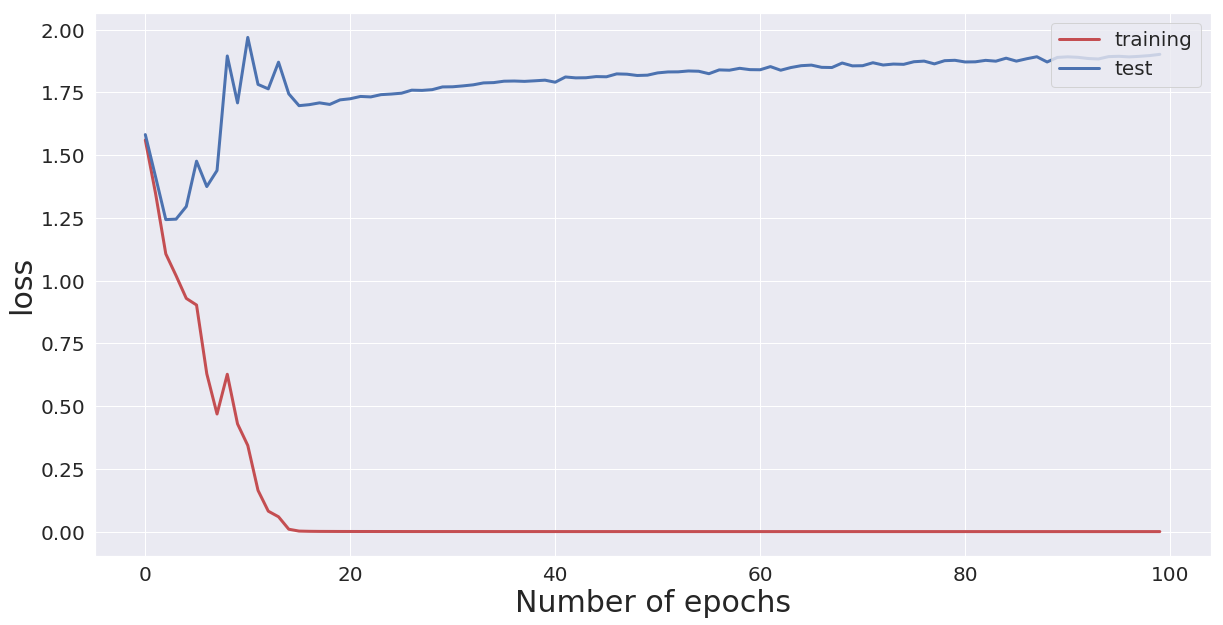

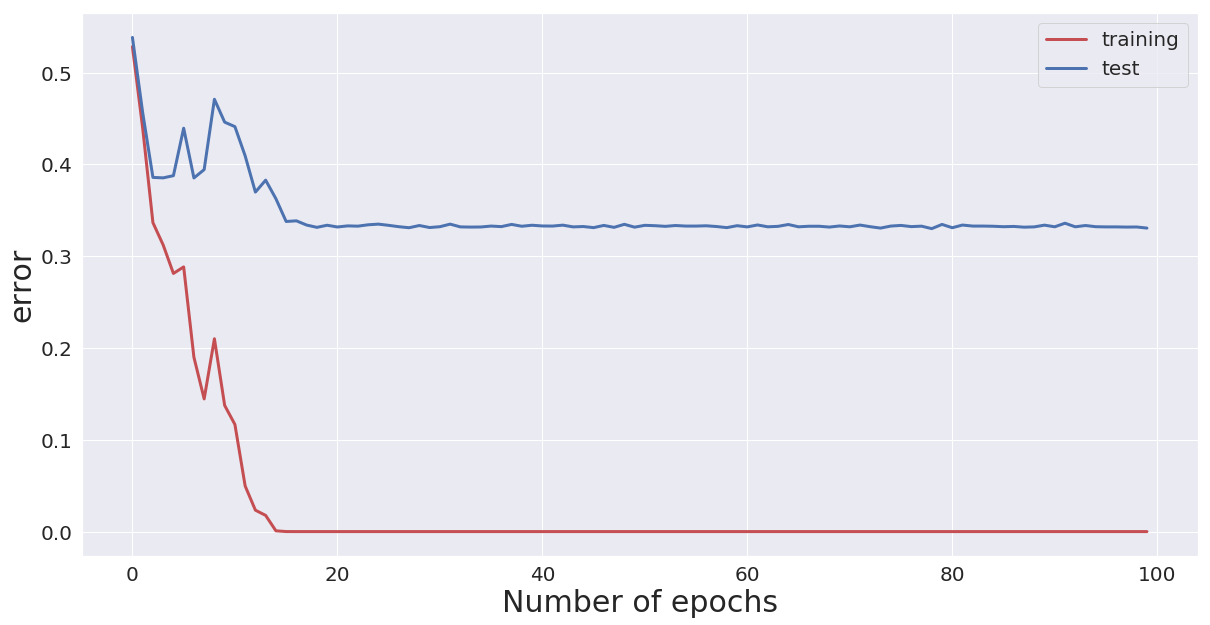

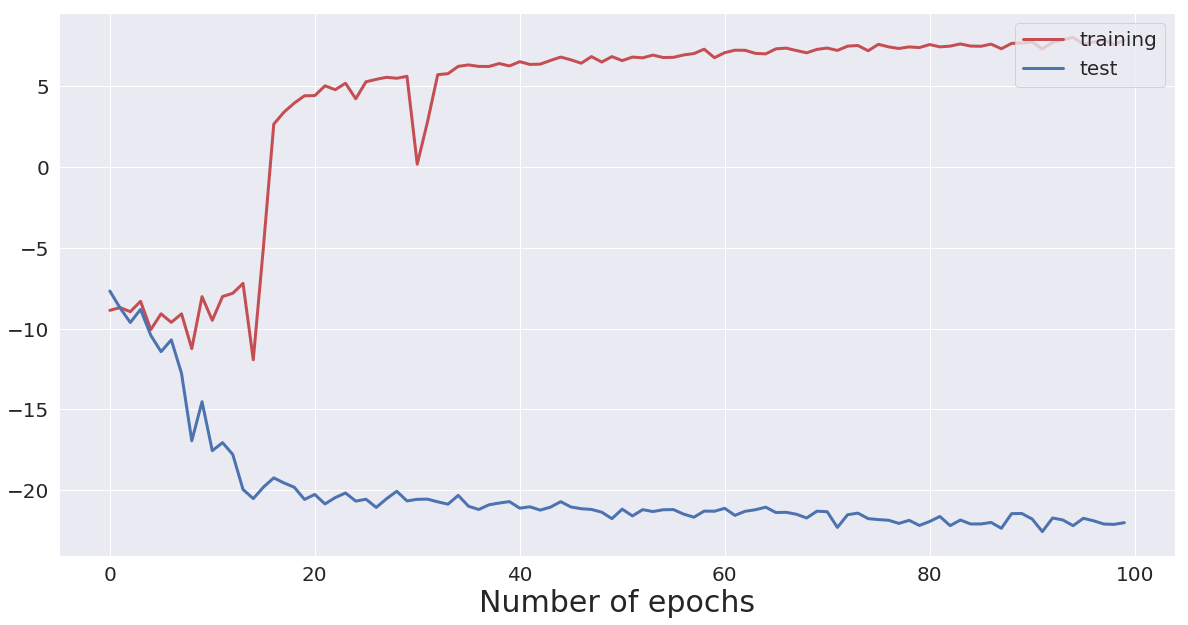

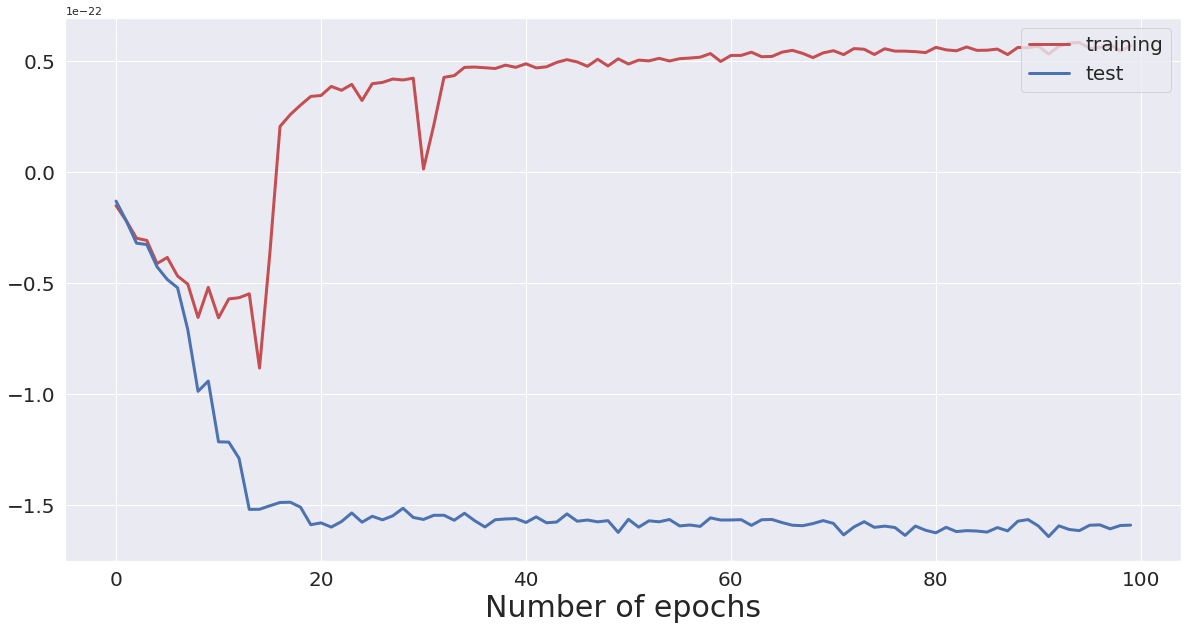

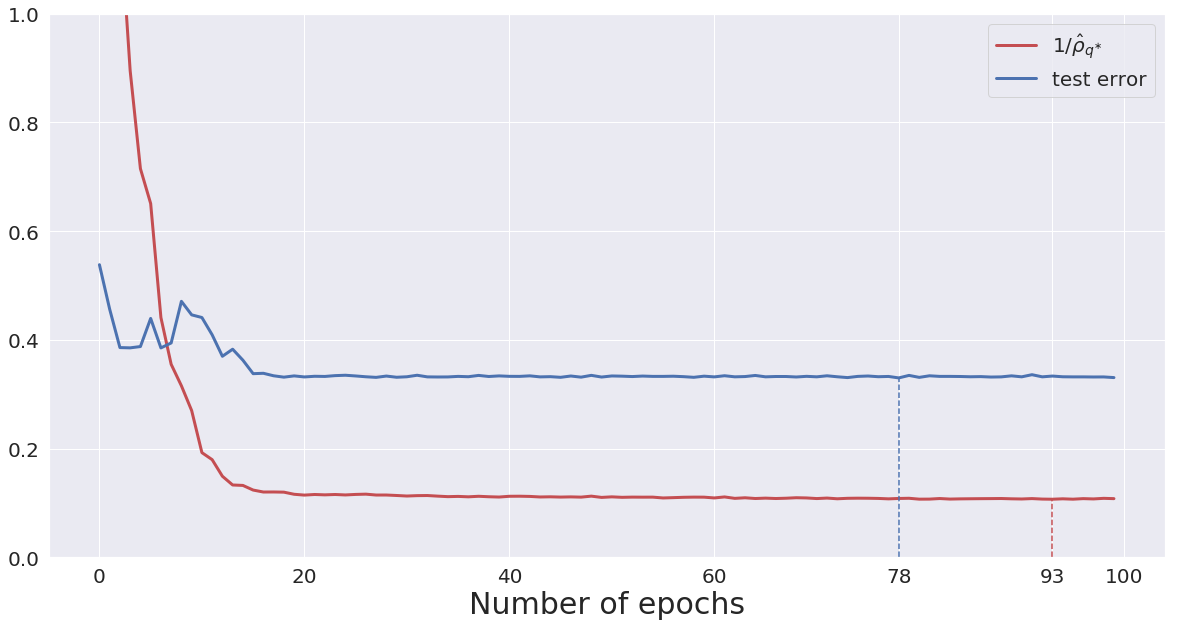

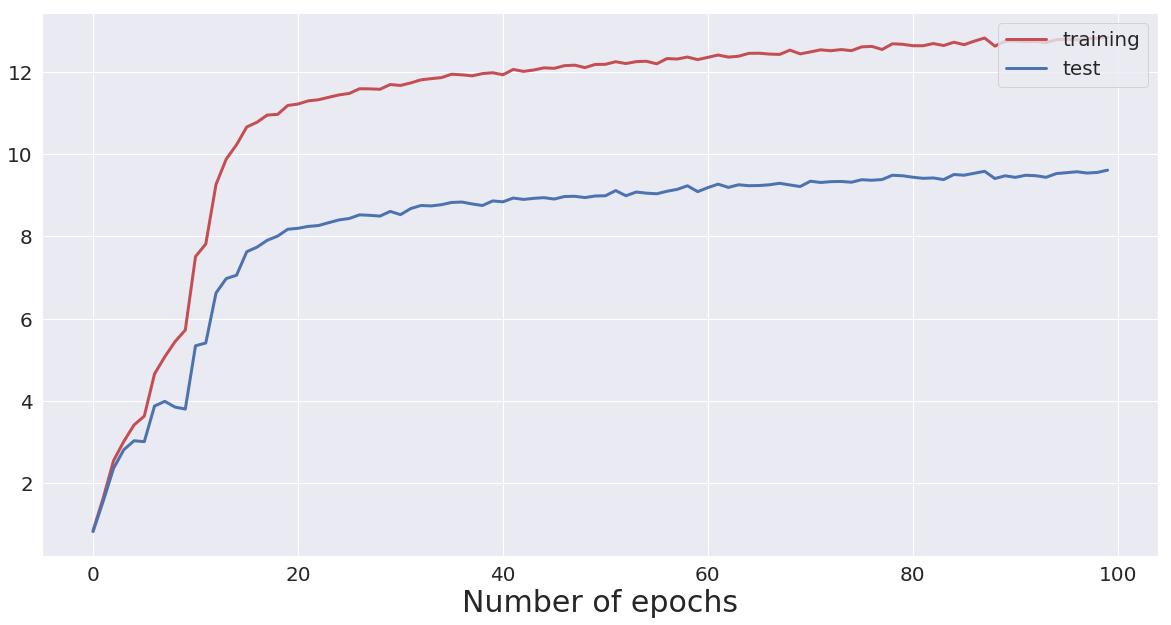

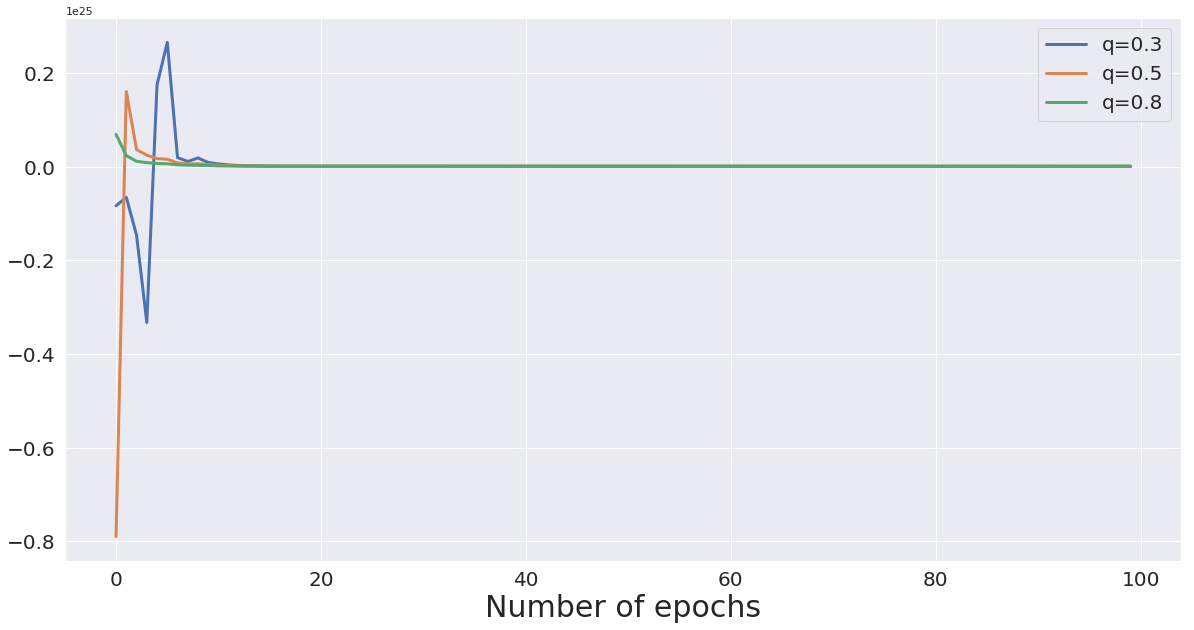

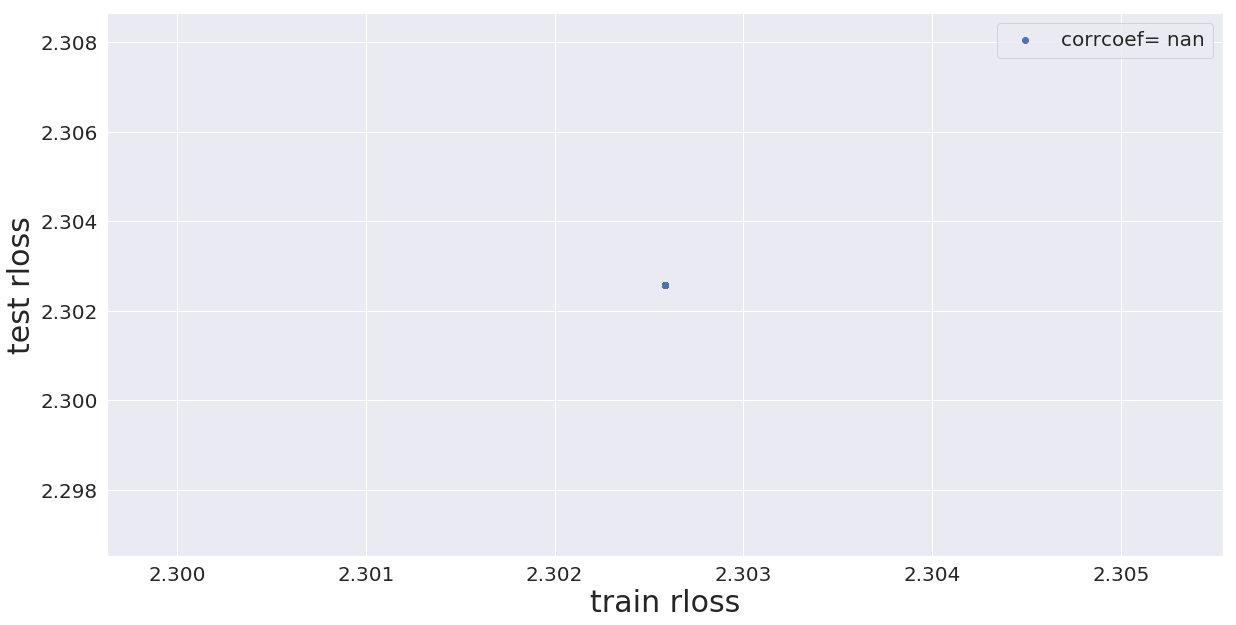

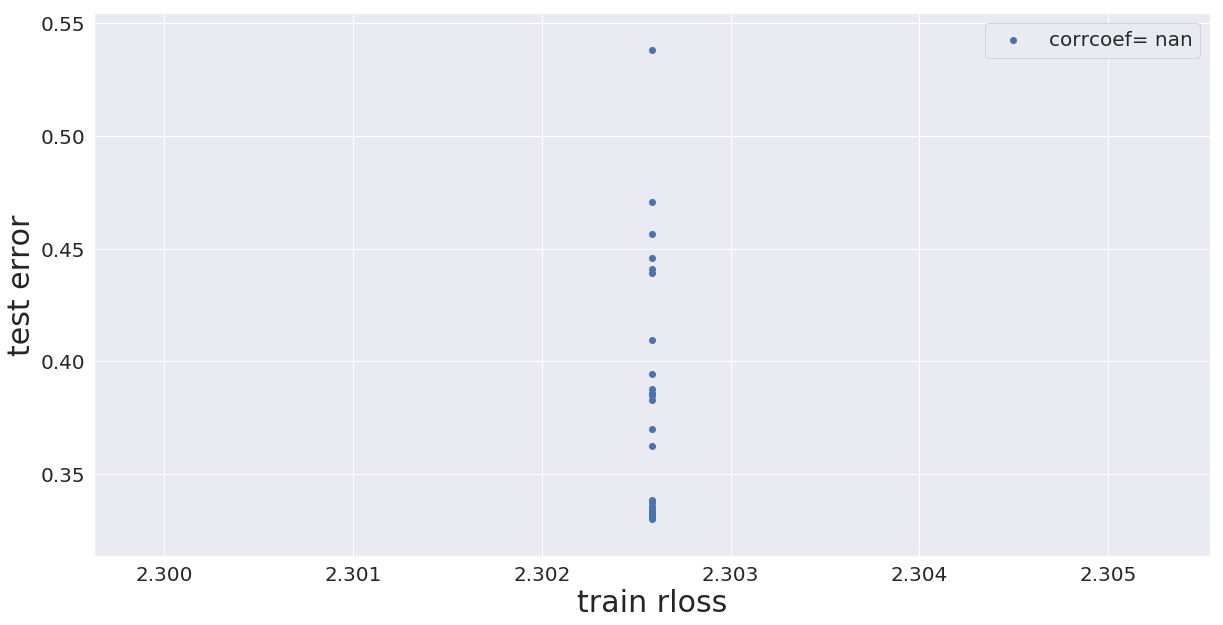

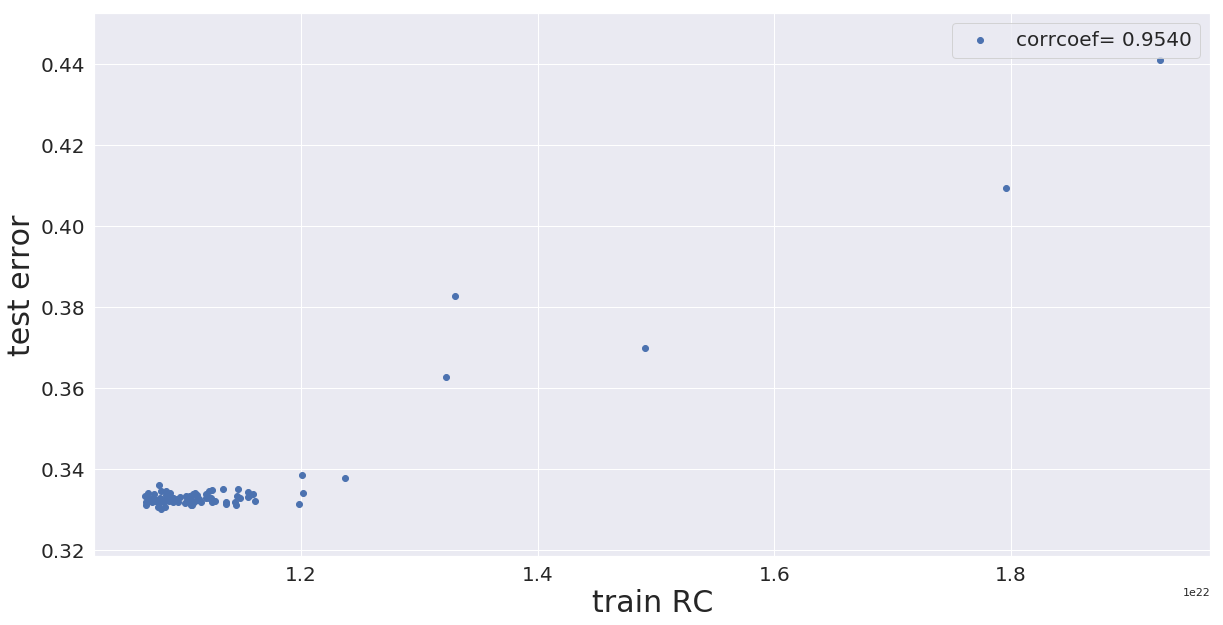

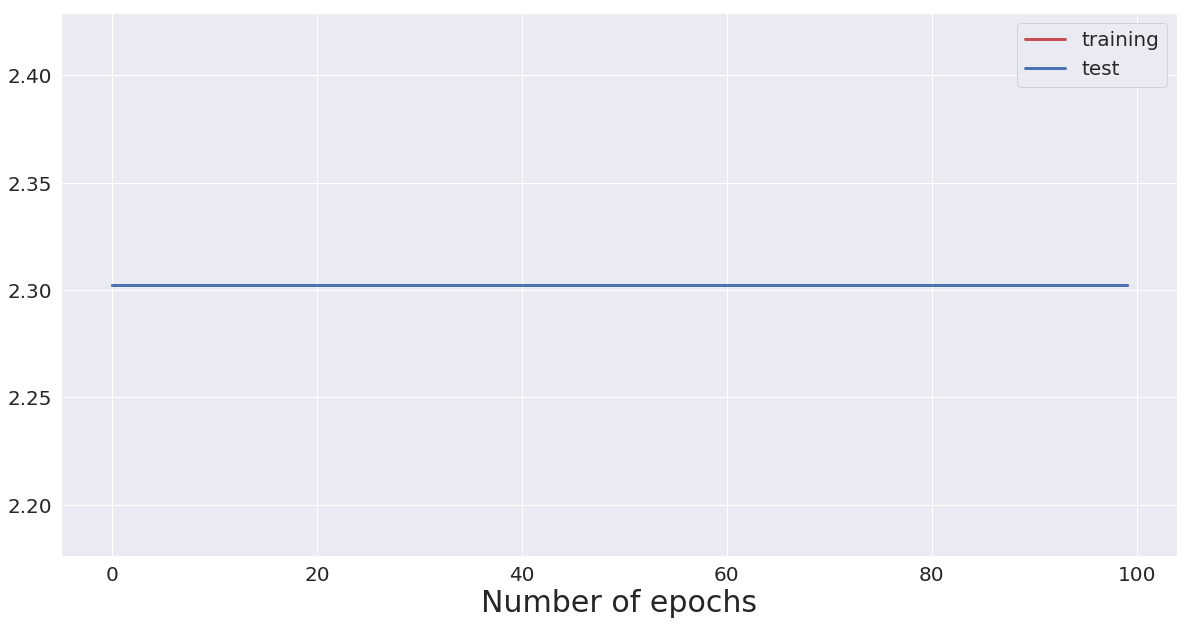

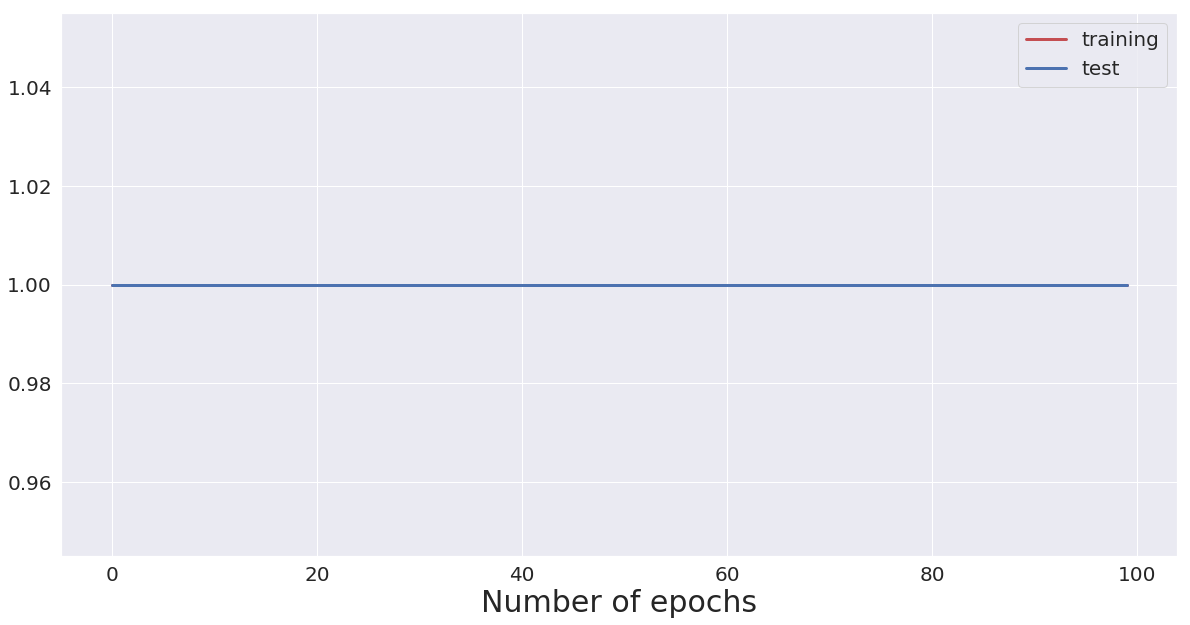

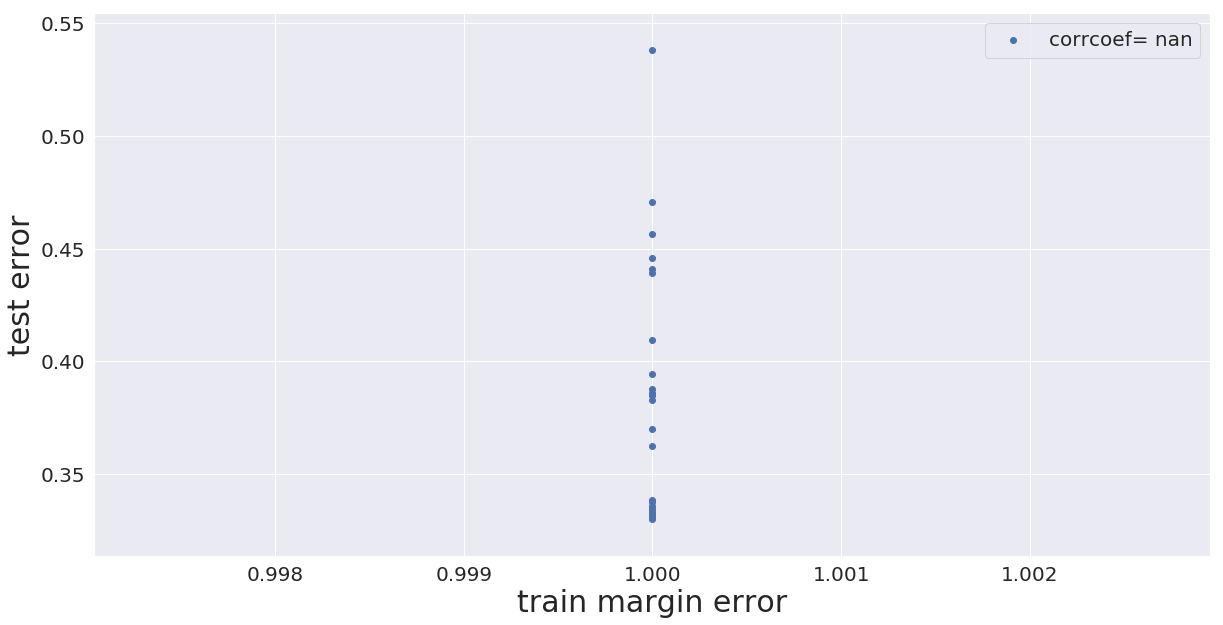

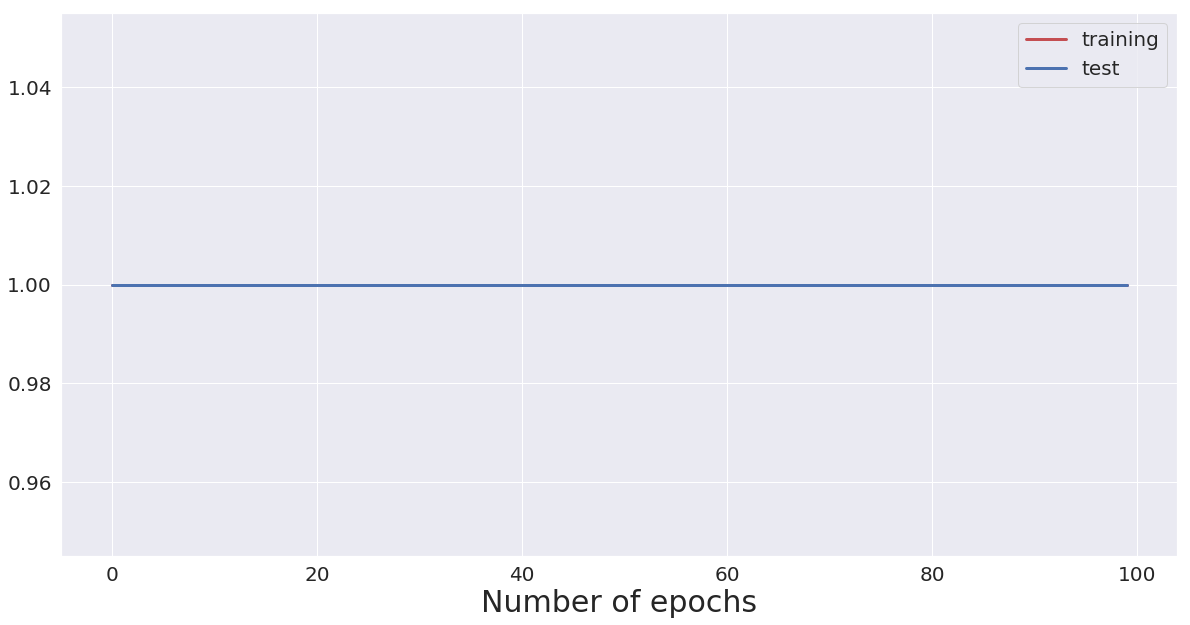

In [39]:
plot(log_1, 0.8, './res18_results_p0.1/')
plt.show()

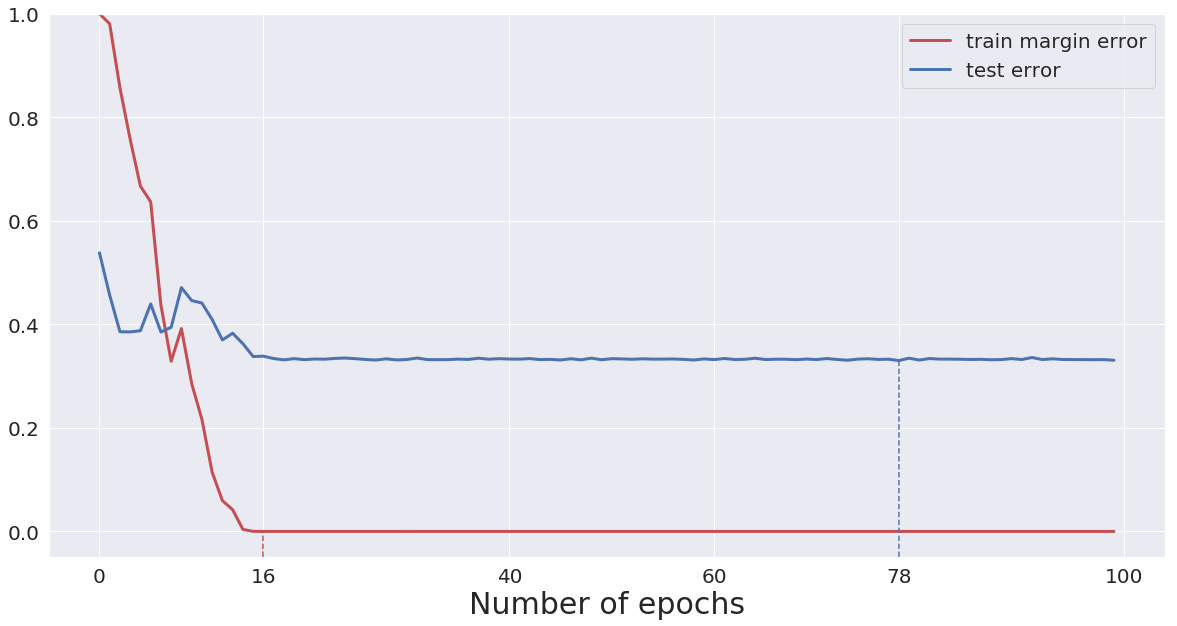

In [40]:
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

train_merror=[margin_error(margin, lip * 1e-23) for (margin, lip) in zip(log_1['margin_train'], log_1['Lip'])]
ax.plot(train_merror
    ,'r',linewidth=3,
    label='train margin error')
ax.plot(log_1['test_error'],'b',linewidth=3,label='test error')
ax.legend(fontsize=20,loc='best')
#ax.set_xlim(0,100)
ax.set_ylim(-0.05,1)
#test_error_dev=[log_1['test_error'][i+1]-log_1['test_error'][i] for i in range(15)]
#x=np.where(np.array(test_error_dev)>0)[0]
#print(x)
#ax.scatter(x,np.array(log_1['test_error'])[x],c='k',s=30)
x1=np.argmin(log_1['test_error'])
ax.plot([x1,x1],[-0.05,log_1['test_error'][x1]],'b--')
x2=np.argmin(train_merror)
ax.plot([x2,x2],[-0.05,train_merror[x2]],'r--')
ax.set_xticks([0,min(x1,x2),max(x1,x2),40,60,100])
ax.set_xlabel('Number of epochs',fontdict={'size': 30})
fig.savefig('./res18_results_p0.1/margin_error_and_test_error.png')
plt.show()

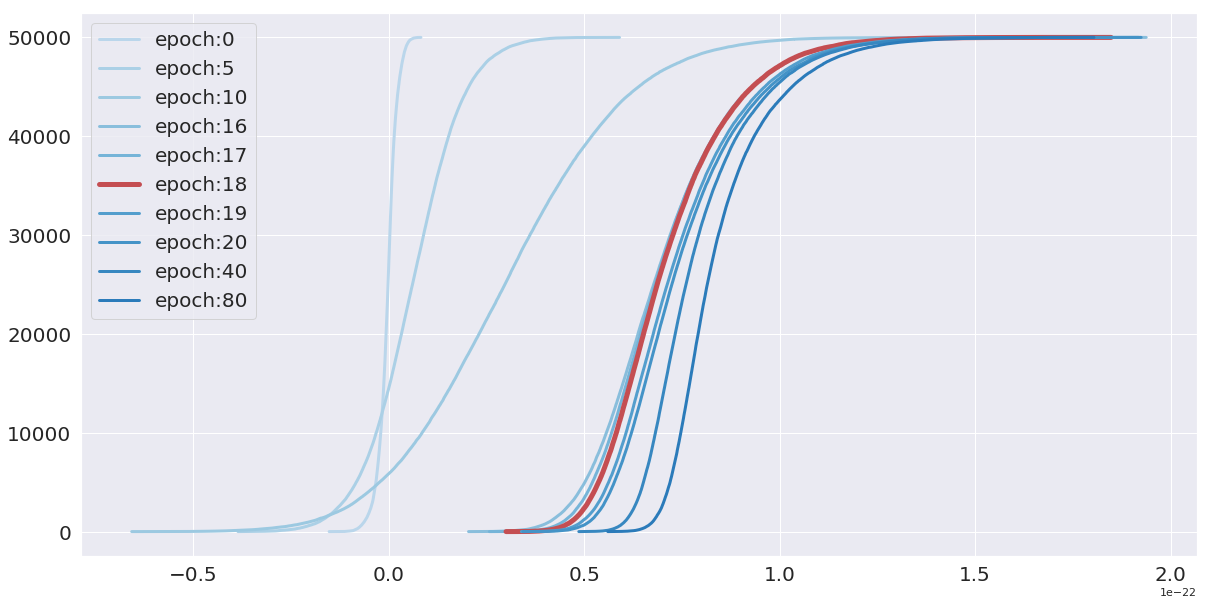

In [21]:
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
#plt.title('Evolutions of normalized margin distributions', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0, 5, 10,16,17,18,19,20, 40, 80]):
    if i==18:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',20)[j+5]
        d=3
    ax.plot(np.sort(log_1['margin_train'][i])/log_1['Lip'][i], range(50000),c=c, label=f'epoch:{i}',linewidth=d)
#ax.set_xlim([-10, 10])
ax.legend(fontsize=20)
fig.savefig('./res18_results_p0.1/'+'nMargin_distribution.png')

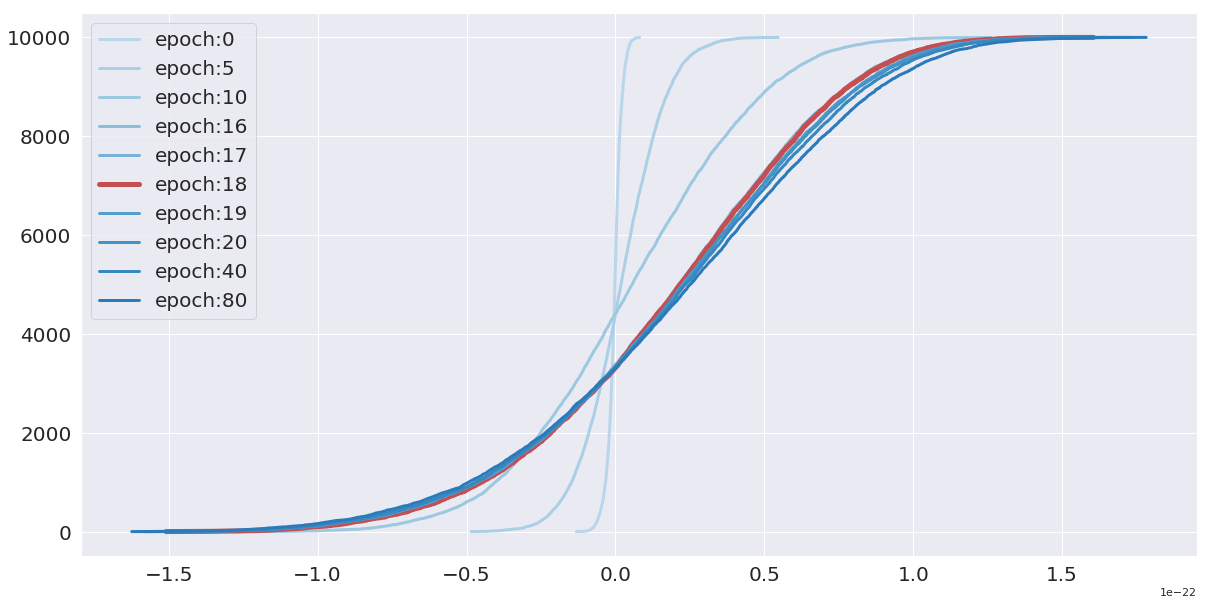

In [22]:
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
#plt.title('Evolutions of normalized margin distributions', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0, 5, 10,16,17,18,19,20, 40, 80]):
    if i==18:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',20)[j+5]
        d=3
    ax.plot(np.sort(log_1['margin_test'][i])/log_1['Lip'][i], range(10000),c=c, label=f'epoch:{i}',linewidth=d)
#ax.set_xlim([-10, 10])
ax.legend(fontsize=20)
fig.savefig('./res18_results_p0.1/'+'test_nMargin_distribution.png')

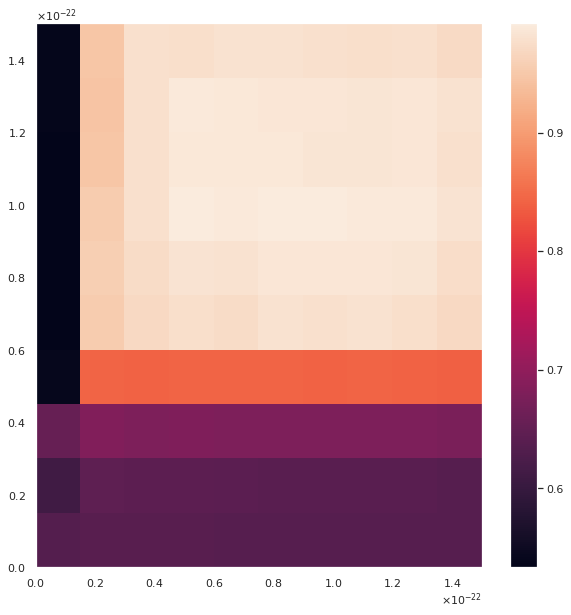

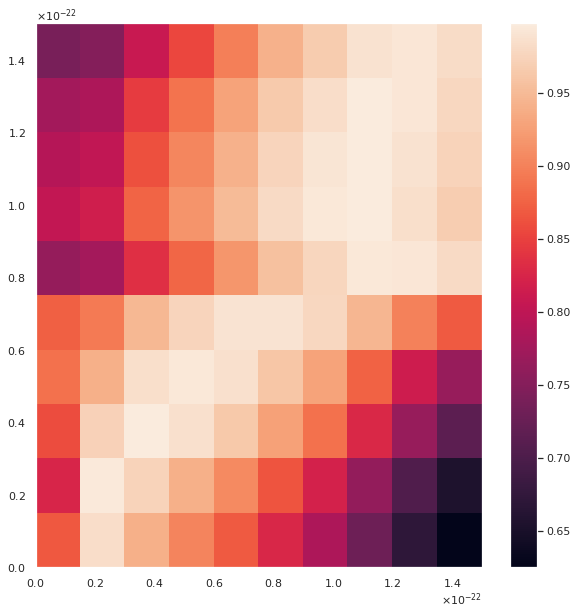

In [25]:
plot_heatmap(log_1,'./res18_results_p0.1/',np.linspace(0,1.5e-22,11))

## Experiment on CIFAR100 and MiniImageNet with noise=0.1 for ResNet18
Sorry, I did not find the original code for training but saved log, so I loaded the saved log for the following figures.
But the similar code can be found in margin_alex.ipynb and margin_vgg16.ipynb, so you can modify them for resnet18.

In [48]:
def plot_heatmap(log,path,interval):
    n=len(interval)
    corr=np.zeros((n,n))
    corr_linear=np.zeros((n,n))
    for i in range(n):
        g1=interval[i]
        train_merror=[margin_error(margin, lip * g1) for (margin, lip) in zip(log['margin_train'], log['Lip'])]
        for j in range(n):
            g2=interval[j]
            test_merror=[margin_error(margin, lip * g2) for (margin, lip) in zip(log['margin_test'], log['Lip'])]
            corr[i,j]=scipy.stats.spearmanr(train_merror,test_merror)[0]
            corr_linear[i,j]=np.corrcoef(train_merror,test_merror)[0,1]
    fig = plt.figure(1, figsize=(20, 10))
    ax = fig.add_subplot(111)
    im=ax.pcolormesh(interval,interval,corr,vmin=-0.8,vmax=0.8)
    fig.colorbar(im)
    ax.axis('tight')
    ax.set_xlabel('$\gamma_{1}$',fontsize=20)
    ax.set_ylabel('$\gamma_{2}$',fontsize=20)
    from matplotlib import ticker
    formatter=ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1))
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    fig.savefig(path+'margin_error_rankcorr.png')
    plt.show()
    
    fig = plt.figure(1, figsize=(10, 10))
    ax = fig.add_subplot(111)
    im=ax.pcolormesh(interval,interval,corr_linear)
    fig.colorbar(im)
    ax.axis('tight')
    from matplotlib import ticker
    formatter=ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1))
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    fig.savefig(path+'margin_error_linearcorr.png')
    plt.show()

In [3]:
import pickle
log_cifar100=pickle.load(open('./res18_results_p0.1/log_cifar100','rb'))

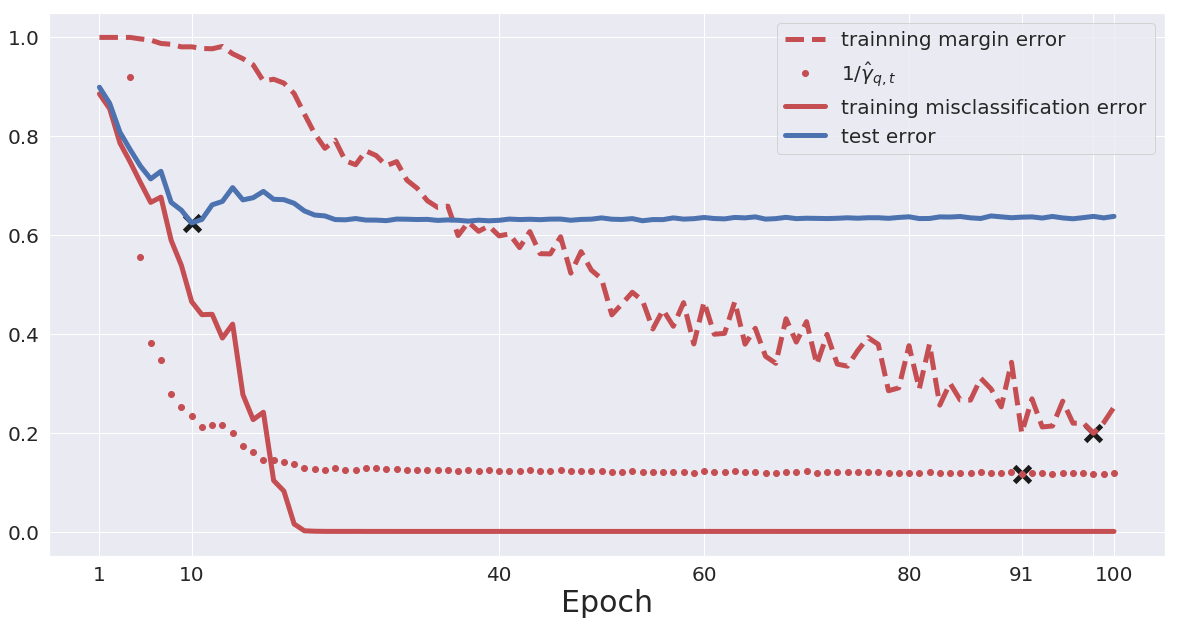

In [52]:
def get_qmargin(margins, q):
    q1 = int(len(margins[0]) * q)
    return [np.partition(margin, q1)[q1] for margin in margins]
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

train_merror=[margin_error(margin, lip * 0.9e-23) for (margin, lip) in zip(log_cifar100['margin_train'], log_cifar100['Lip'])]
nqMargin_train = np.array(get_qmargin(log_cifar100['margin_train'],
                                                 0.9)) / np.array(log_cifar100['Lip'])*8e23

ax.plot(train_merror
    ,'r--',linewidth=5,
    label='trainning margin error')
ax.plot(1/nqMargin_train,'ro', linewidth=5, label=r'$1/\hat{\gamma}_{q,t}$')

ax.plot(log_cifar100['train_error'],'r',linewidth=5,label='training misclassification error')
ax.plot(log_cifar100['test_error'],'b',linewidth=5,label='test error')

#ax.set_xlim(0,100)
ax.set_ylim(-0.05,1.05)
x1=np.argmin(log_cifar100['test_error'])
ax.scatter(x1,log_cifar100['test_error'][x1],s=250,c='k',marker='x',linewidth=5)
x2=np.argmin(train_merror)
ax.scatter(x2,train_merror[x2],s=250,c='k',marker='x',linewidth=5)

ax.set_xlabel('Epoch',fontdict={'size': 30})
#fig.savefig('./results_original/margin_error_and_test_error.png')


x3=np.argmin(1/nqMargin_train)
ax.scatter(x3,1/nqMargin_train[x3],s=250,c='k',marker='x',linewidth=5)
ax.set_xticks([0,x1,x2,x3,39,59,79,99])
ax.set_xticklabels([1,x1+1,'',x3+1,40,60,80,100])
ax.legend(loc='best',fontsize=20)
fig.savefig('./res18_results_p0.1/cifar100_margin_error_and_test_error.png')

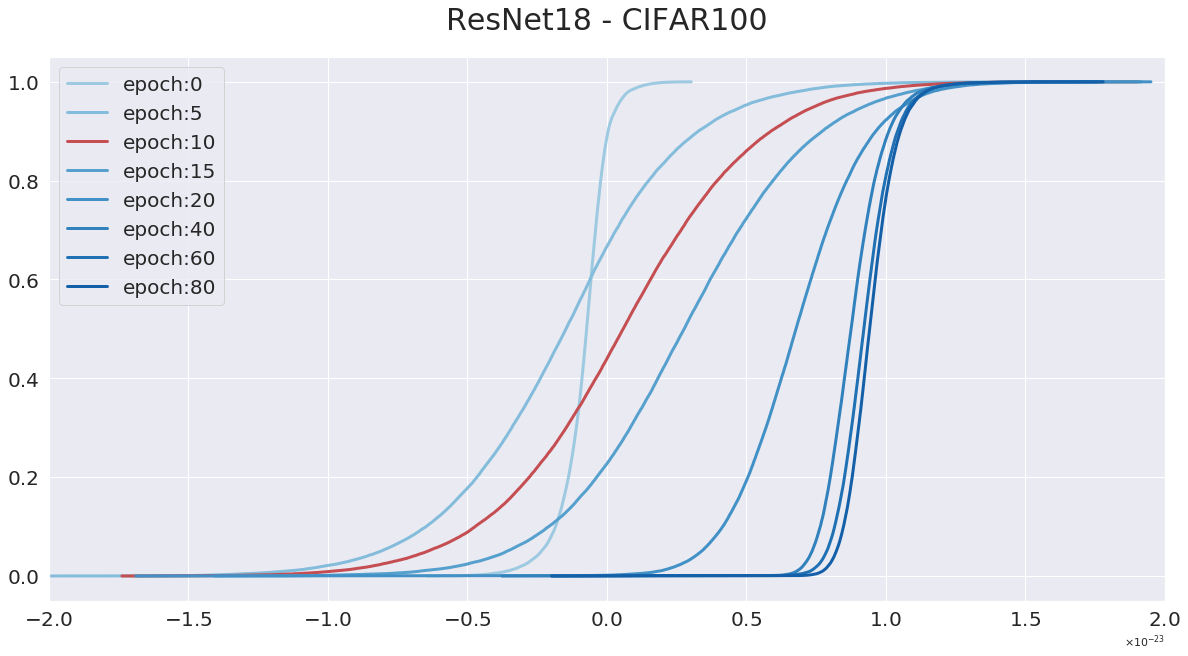

In [17]:
#
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.title('ResNet18 - CIFAR100', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0, 5, 10,15,20,40,60, 80]):
    if i==10:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',15)[j+5]
        d=3
    ax.plot(np.sort(log_cifar100['margin_train'][i])/log_cifar100['Lip'][i], np.arange(50000)/50000, label=f'epoch:{i}',linewidth=3,c=c)
ax.set_xlim([-2e-23, 2e-23])
ax.legend(fontsize=20)
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
fig.savefig('./res18_results_p0.1/'+'cifar100_nMargin_distribution.png')

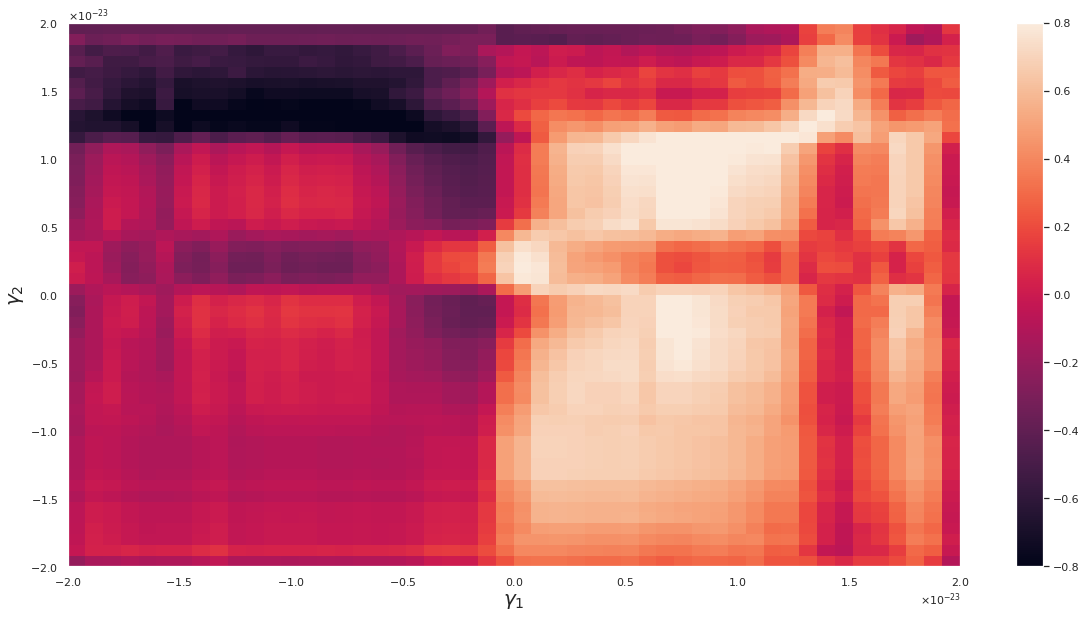

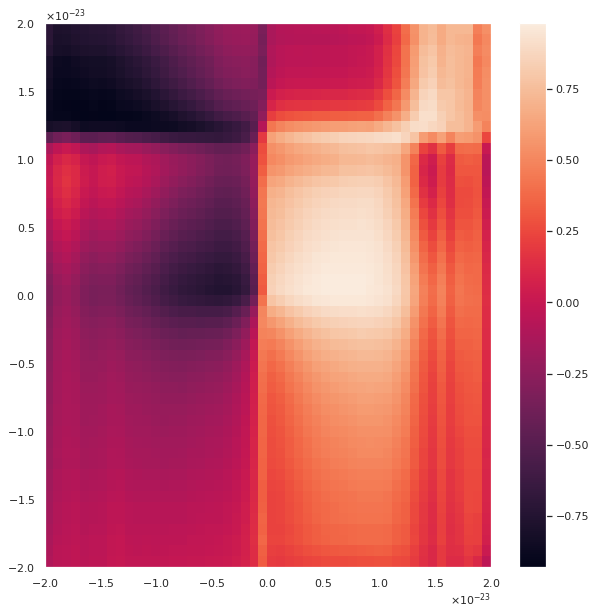

In [49]:
plot_heatmap(log_cifar100,'./res18_results_p0.1/cifar100_',np.linspace(-2e-23,2e-23,51))

In [9]:
import pickle
log_mini=pickle.load(open('./res18_results_p0.1/log_mini','rb'))

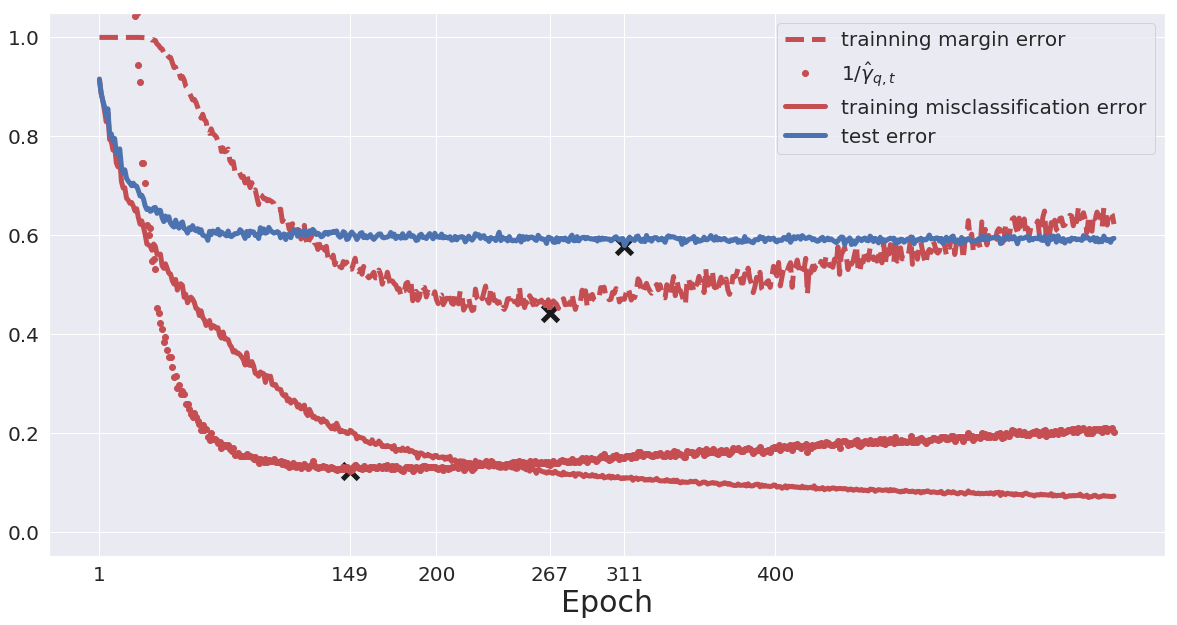

In [47]:
def get_qmargin(margins, q):
    q1 = int(len(margins[0]) * q)
    return [np.partition(margin, q1)[q1] for margin in margins]
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

train_merror=[margin_error(margin, lip *1e-22) for (margin, lip) in zip(log_mini['margin_train'], log_mini['Lip'])]
nqMargin_train = np.array(get_qmargin(log_mini['margin_train'],
                                                 0.95)) / np.array(log_mini['Lip'])*3e22

ax.plot(train_merror
    ,'r--',linewidth=5,
    label='trainning margin error')
ax.plot(1/nqMargin_train,'ro', linewidth=5, label=r'$1/\hat{\gamma}_{q,t}$')

ax.plot(log_mini['train_error'],'r',linewidth=5,label='training misclassification error')
ax.plot(log_mini['test_error'],'b',linewidth=5,label='test error')

#ax.set_xlim(0,100)
ax.set_ylim(-0.05,1.05)
x1=np.argmin(log_mini['test_error'])
ax.scatter(x1,log_mini['test_error'][x1],s=250,c='k',marker='x',linewidth=5)
x2=np.argmin(train_merror)
ax.scatter(x2,train_merror[x2],s=250,c='k',marker='x',linewidth=5)

ax.set_xlabel('Epoch',fontdict={'size': 30})
#fig.savefig('./results_original/margin_error_and_test_error.png')


x3=np.argmin(1/nqMargin_train)
ax.scatter(x3,1/nqMargin_train[x3],s=250,c='k',marker='x',linewidth=5)
ax.set_xticks([0,x1,x2,x3,199,399])
ax.set_xticklabels([1,x1+1,x2+1,x3+1,200,400])
ax.legend(loc='best',fontsize=20)
#plt.show()
fig.savefig('./res18_results_p0.1/mini_margin_error_and_test_error.png')

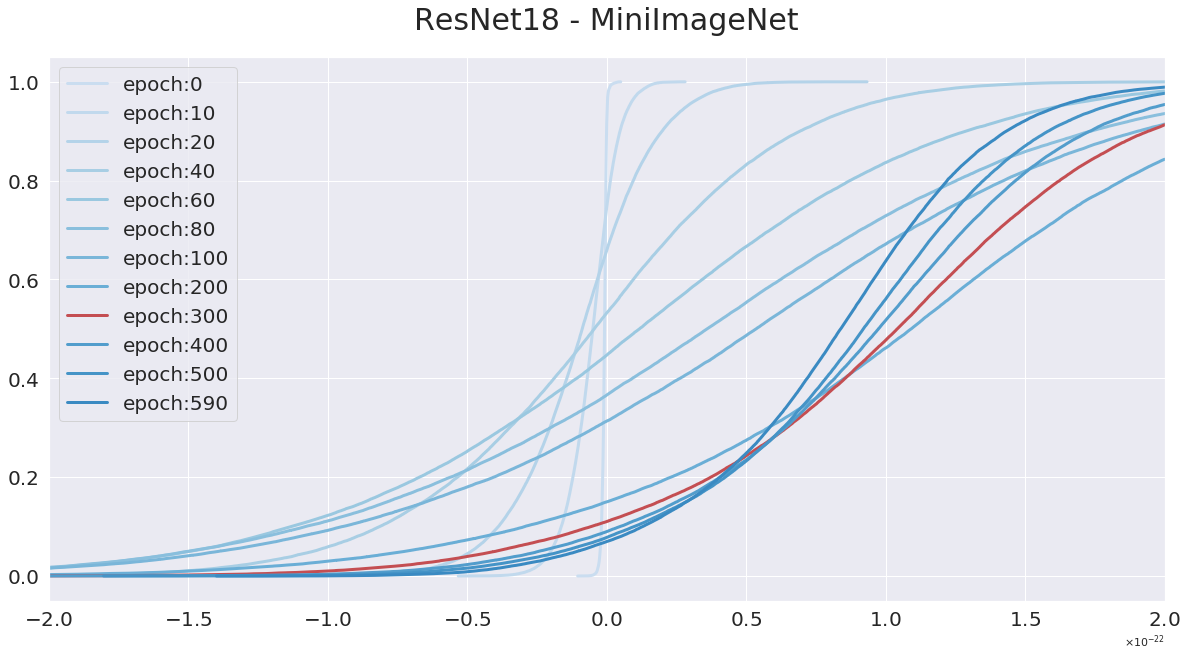

In [16]:
#
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.title('ResNet18 - MiniImageNet', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0,10,20,40,60,80,100,200,300,400,500,590]):
    if i==300:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',25)[j+5]
        d=3
    ax.plot(np.sort(log_mini['margin_train'][i])/log_mini['Lip'][i], np.arange(50000)/50000, label=f'epoch:{i}',linewidth=3,c=c)
ax.set_xlim([-2e-22, 2e-22])
#ax.set_xticks([0])
ax.legend(fontsize=20)
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
fig.savefig('./res18_results_p0.1/'+'mini_nMargin_distribution.png')

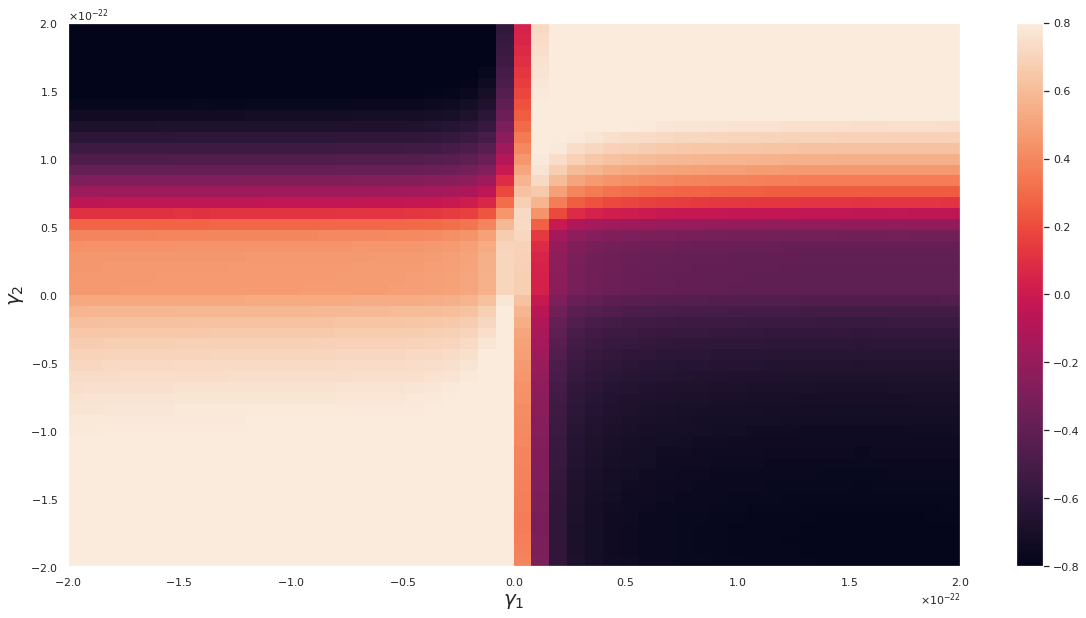

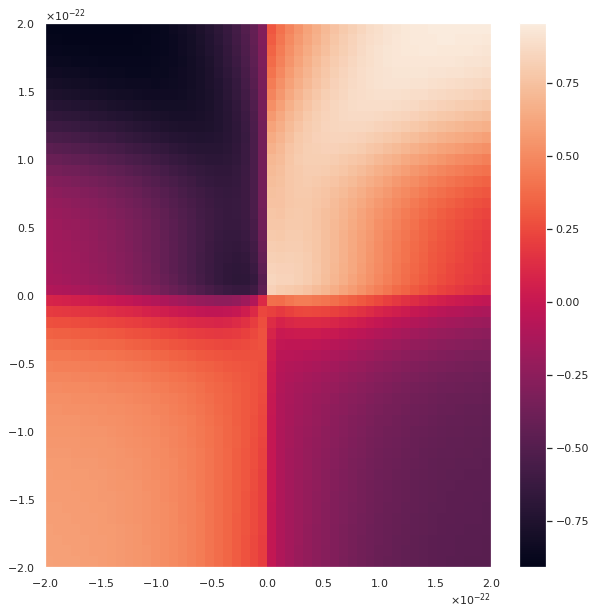

In [50]:
plot_heatmap(log_mini,'./res18_results_p0.1/mini_',np.linspace(-2e-22,2e-22,51))